In [30]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
%matplotlib inline
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

def convert_df_columns(df):
    df_converted = pd.DataFrame()
    
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            # Convert datetime to Unix timestamp (float)
            df_converted[col] = df[col].astype('int64') / 1e9
        elif pd.api.types.is_string_dtype(df[col]):
            # Apply one-hot encoding to string columns
            df_converted = pd.concat([df_converted, pd.get_dummies(df[col], prefix=col)], axis=1)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Leave numeric columns as is
            df_converted[col] = df[col]
        else:
            try:
                # Try converting to int first
                df_converted[col] = df[col].astype(int)
            except ValueError:
                try:
                    # If int conversion fails, try converting to float
                    df_converted[col] = df[col].astype(float)
                except ValueError:
                    print(f"Column {col} cannot be converted to int or float.")

    return df_converted

def drop_all_nan_columns(df):
    # Identify columns where all values are NaN
    columns_to_drop = df.columns[df.isna().all()]

    # Drop these columns
    df_cleaned = df.drop(columns=columns_to_drop)

    # Convert columns_to_drop to a list for easy use
    dropped_columns_list = columns_to_drop.tolist()

    # Optionally, report how many and which columns were dropped
    if dropped_columns_list:
        print(f"Dropped columns: {dropped_columns_list}")
    else:
        print("No columns were dropped.")

    return df_cleaned, dropped_columns_list


##WITHOUT GRIDSEARCH

def initialize_model(input_columns,output_columns,M1,M2,T):
    
    model_0 = Sequential([
        LSTM(M1, return_sequences=True, input_shape=(T, len(input_columns))),
        Dropout(0.1),
        LSTM(M1, return_sequences=False),
        Dropout(0.1),
        Dense(M2, activation='relu'),
        Dense(len(output_columns), activation='linear')
    ])
    return model_0

def create_lstm_input_with_output(data, T, output_col_index):
    """
    Convert a dataset into a format suitable for LSTM training, including past output values.

    Parameters:
    data (np.array): Input dataset with D columns (including output).
    T (int): Length of the time window.
    output_col_index (int): Index of the output column in data.

    Returns:
    np.array: A 3D array suitable for LSTM training, with shape (N, T, D).
    """
    N = len(data) - T
    D = data.shape[1]
    X = np.zeros((N, T, D))
    
    for i in range(N):
        X[i, :, :-1] = data[i:i+T, :-1]  # Input features up to time t
        X[i, 1:, -1] = data[i:i+T-1, output_col_index]  # Output feature up to time t-1
        # Note: First element of output feature is not set, defaults to zero

    return X

def create_lstm_input(data, T, output_col_index):
    """
    Convert a dataset into a format suitable for LSTM training, including past output values.

    Parameters:
    data (np.array): Input dataset with D columns (including output).
    T (int): Length of the time window.
    output_col_index (int): Index of the output column in data.

    Returns:
    np.array: A 3D array suitable for LSTM training, with shape (N, T, D).
    """
    N = len(data) - T
    D = data.shape[1]
    X = np.zeros((N, T, D))
    
    for i in range(N):
        X[i, :, :] = data[i:i+T, :]  # Input features up to time t
        #X[i, 1:, -1] = data[i:i+T-1, output_col_index]  # Output feature up to time t-1
        # Note: First element of output feature is not set, defaults to zero

    return X


def create_output_array(data, T, output_col_index):
    """
    Create the output array for LSTM training.

    Parameters:
    data (np.array): Input dataset with D columns (including output).
    T (int): Length of the time window.
    output_col_index (int): Index of the output column in data.

    Returns:
    np.array: Output array for LSTM training.
    """
    # The output value for each sequence is the output at time t (end of the sequence)
    y = data[T:, output_col_index]

    return y

def create_in_and_out(df,T,input_col,output_col):
    N = len(df) - T -1
    D = len(input_col+output_col)
    X = np.zeros((N, T+1, D))
    Y=np.zeros(N)

    for t in range(N):
        x=df[input_col].iloc[t:t+T+1] #all data from t to t+T included
        x_tar=df[output_col].iloc[t:t+T]  #all targets ffrom t to t+T EXCLUDED

        x_tar=pd.concat([x_tar,pd.DataFrame(x_tar.iloc[0].values,columns=x_tar.columns)], ignore_index=True)#inpute the last value as the first to match dimensions
        #x=pd.concat([x,x_tar], ignore_index=True,axis=1) #unite the two
        x[output_col]=x_tar.values

        X[t, :, :]=x.values
        
        y=df[output_col].iloc[t+T]
        Y[t]=y.values
    return(X,Y)
        
        

def create_in_and_out_optimized(df, T, y_real,input_col, output_col,scaled=np.nan):
    # Convert to numpy for faster operations
    input_data = df[input_col].values
    output_data = df[output_col].values
    y_real=y_real.values
    
    N = len(df) - T - 1
    D = len(input_col) + len(output_col)
    X = np.zeros((N, T + 1, D))
    Y = np.zeros(N)
    IC=np.ones(N)

    for t in range(N):
        # Extract input data for current window
        x = input_data[t:t + T + 1]

        # Extract output data for current window, and append the last row
        x_tar = output_data[t:t + T]
        x_tar_with_last = np.vstack([x_tar, x_tar[-1]])

        # Combine input and modified output data
        combined_data = np.hstack([x, x_tar_with_last])

        # Assign to X
        X[t, :, :] = combined_data

        # Assign to Y
        Y[t] = y_real[t + T]
        if len(scaled)>1:
            IC[t]=scaled.values[t+T]
    return X, Y, IC


lstm_inputs={}



lstm_input_0=['county',
'installed_capacity'
#'is_business',
#'product_type',
#'is_consumption',
'weekday',
'hour_of_day',
'day_of_month',
'month',
'es_festive',
#'product_type_county_is_business',
'eic_count',
'temperature_f',
'dewpoint_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'10_metre_u_wind_component_f',
'10_metre_v_wind_component_f',
'direct_solar_radiation_f',
'surface_solar_radiation_downwards_f',
'snowfall_f',
'total_precipitation_f',
#'latitude_f',
#'longitude_f',
'hours_ahead_f',
'euros_per_mwh']


lstm_input_1=['county',
#'installed_capacity'
#'is_business',
'product_type',
#'is_consumption',
'weekday',
'hour_of_day',
'day_of_month',
'month',
'es_festive',
#'product_type_county_is_business',
'eic_count',
'temperature_f',
'dewpoint_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'10_metre_u_wind_component_f',
'10_metre_v_wind_component_f',
'direct_solar_radiation_f',
'surface_solar_radiation_downwards_f',
'snowfall_f',
'total_precipitation_f',
#'latitude_f',
#'longitude_f',
'hours_ahead_f',
'euros_per_mwh']



lstm_inputs['0']=lstm_input_0
lstm_inputs['1']=lstm_input_1


In [10]:
save_id='all_puis'
df_dict=joblib.load(r"./train_dataset_complete_{}.pkl".format(save_id))



In [53]:

for key in df_dict:
    print(key)

0_c0_b0
1_c0_b0
2_c0_b0
6_c0_b0
7_c0_b0
9_c0_b0
11_c0_b0
12_c0_b0
15_c0_b0
16_c0_b0
19_c0_b0
20_c0_b0
25_c0_b0
26_c0_b0
27_c0_b0
31_c0_b0
32_c0_b0
34_c0_b0
35_c0_b0
38_c0_b0
39_c0_b0
43_c0_b0
44_c0_b0
45_c0_b0
50_c0_b0
51_c0_b0
53_c0_b0
54_c0_b0
57_c0_b0
58_c0_b0
62_c0_b0
0_c1_b0
1_c1_b0
2_c1_b0
6_c1_b0
7_c1_b0
9_c1_b0
11_c1_b0
12_c1_b0
15_c1_b0
16_c1_b0
19_c1_b0
20_c1_b0
25_c1_b0
26_c1_b0
27_c1_b0
31_c1_b0
32_c1_b0
34_c1_b0
35_c1_b0
38_c1_b0
39_c1_b0
43_c1_b0
44_c1_b0
45_c1_b0
50_c1_b0
51_c1_b0
53_c1_b0
54_c1_b0
57_c1_b0
58_c1_b0
62_c1_b0


8


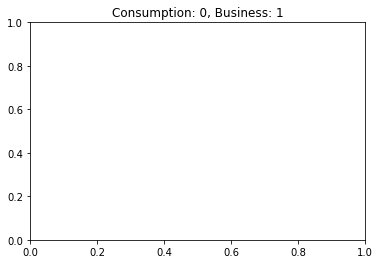

8


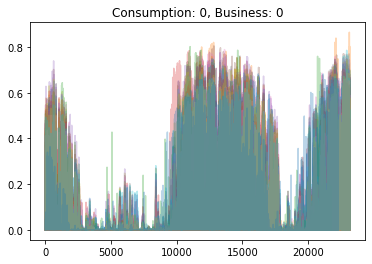

8


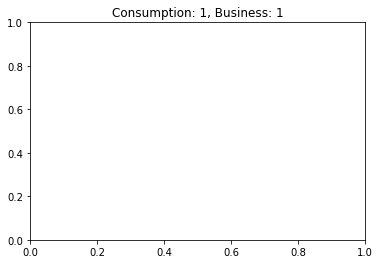

8


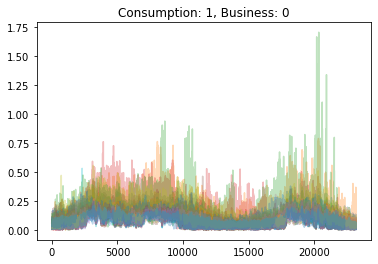

In [50]:
for is_consumption in ['0','1']:
    filtered_cons = {key: value for key, value in df_dict.items() if 'c{}'.format(is_consumption) in key}
    input_columns=lstm_inputs[is_consumption]
    
    for is_business in ['1','0']:

        filtered_items = {key: value for key, value in filtered_cons.items() if 'b{}'.format(is_business) in key}
        sampled_dict = {key: sample_dataframe(df) for key, df in filtered_items.items()}
        
        print(len(key))
        for key in sampled_dict:#filtered_items: 
            df=filtered_items[key]
            plt.plot(df['target_normalized'],alpha=0.3)
        plt.title('Consumption: {}, Business: {}'.format(is_consumption,is_business))
        plt.show()


(152500, 279)
['county', 'product_type', 'weekday', 'hour_of_day', 'day_of_month', 'month', 'es_festive', 'eic_count', 'temperature_f', 'dewpoint_f', 'cloudcover_high_f', 'cloudcover_low_f', 'cloudcover_mid_f', 'cloudcover_total_f', '10_metre_u_wind_component_f', '10_metre_v_wind_component_f', 'direct_solar_radiation_f', 'surface_solar_radiation_downwards_f', 'snowfall_f', 'total_precipitation_f', 'hours_ahead_f', 'euros_per_mwh']
Starting training
Training on dataframe: 0_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 43s 295ms/step
MAE for the current dataframe: 95.03564115263862
MAE for the current dataframe on ['target_normalized']: 0.01913474313914776


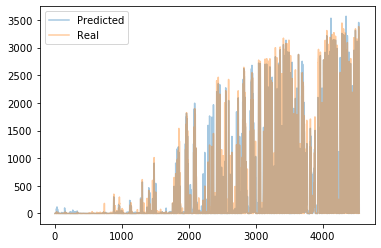

Training on dataframe: 1_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 32s 221ms/step
MAE for the current dataframe: 2.370791684094245
MAE for the current dataframe on ['target_normalized']: 0.022522855550050735


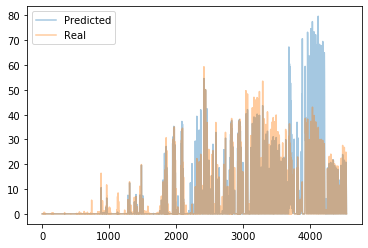

Training on dataframe: 2_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 35s 242ms/step
MAE for the current dataframe: 216.33252319435167
MAE for the current dataframe on ['target_normalized']: 0.014858918264508247


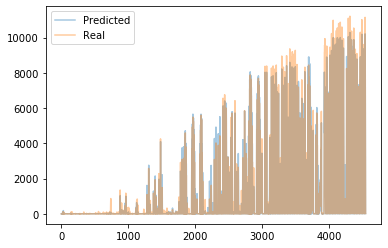

Training on dataframe: 6_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 29s 204ms/step
MAE for the current dataframe: 2.8470928519016807
MAE for the current dataframe on ['target_normalized']: 0.016854388639330864


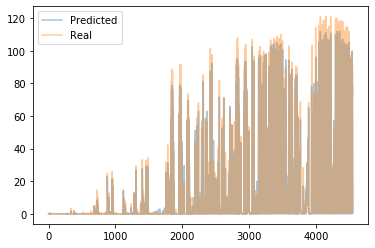

Training on dataframe: 7_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 29s 204ms/step
MAE for the current dataframe: 8.875710302720618
MAE for the current dataframe on ['target_normalized']: 0.014297928661108017


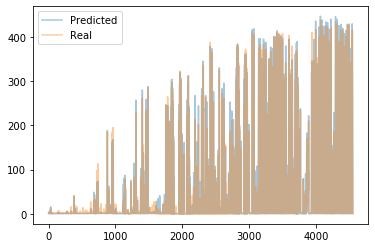

Training on dataframe: 9_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 29s 204ms/step
MAE for the current dataframe: 11.169927243351779
MAE for the current dataframe on ['target_normalized']: 0.013709424063563347


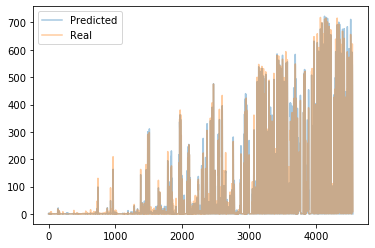

Training on dataframe: 11_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 35s 243ms/step
MAE for the current dataframe: 6.705294443871201
MAE for the current dataframe on ['target_normalized']: 0.01604541949927807


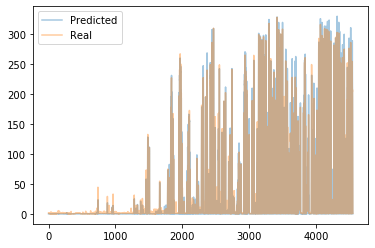

Training on dataframe: 12_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 30s 207ms/step
MAE for the current dataframe: 23.29475612416334
MAE for the current dataframe on ['target_normalized']: 0.015207162126898766


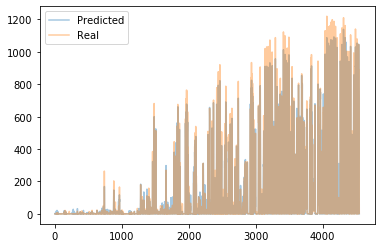

Training on dataframe: 15_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 21s 146ms/step
MAE for the current dataframe: 4.156912967287175
MAE for the current dataframe on ['target_normalized']: 0.009611283428966999


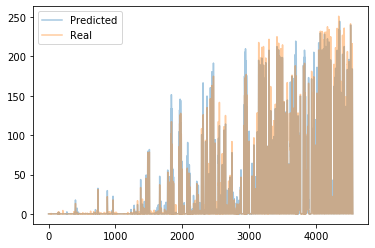

Training on dataframe: 16_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 21s 145ms/step
MAE for the current dataframe: 13.597474199065902
MAE for the current dataframe on ['target_normalized']: 0.010496959090232849


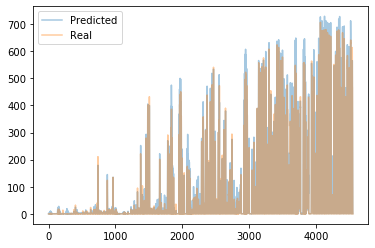

Training on dataframe: 19_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 20s 137ms/step
MAE for the current dataframe: 7.100104875734942
MAE for the current dataframe on ['target_normalized']: 0.011058327741920948


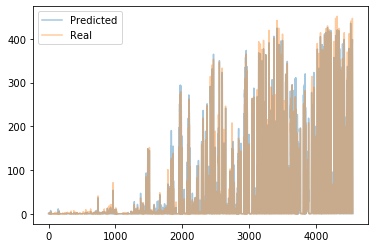

Training on dataframe: 20_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 20s 137ms/step
MAE for the current dataframe: 40.27682775541497
MAE for the current dataframe on ['target_normalized']: 0.016914373263716698


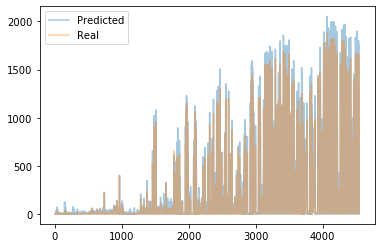

Training on dataframe: 25_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 20s 141ms/step
MAE for the current dataframe: 14.193378131011235
MAE for the current dataframe on ['target_normalized']: 0.011202743276953697


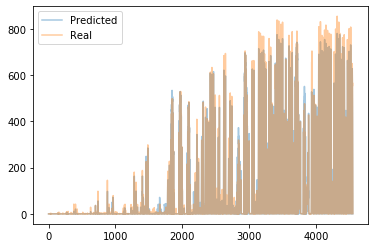

Training on dataframe: 26_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
100/100 [==============================] - 13s 127ms/step
MAE for the current dataframe: 0.47344427308022774
MAE for the current dataframe on ['target_normalized']: 0.0099093709141016


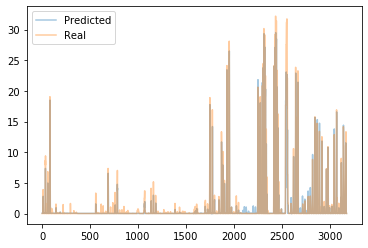

Training on dataframe: 27_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 19s 131ms/step
MAE for the current dataframe: 46.44150330301167
MAE for the current dataframe on ['target_normalized']: 0.012865866534411907


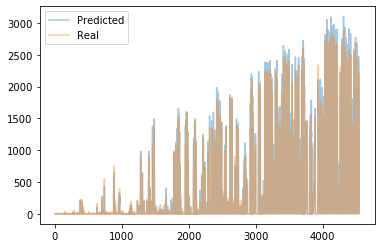

Training on dataframe: 31_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 18s 129ms/step
MAE for the current dataframe: 5.374347025429485
MAE for the current dataframe on ['target_normalized']: 0.007663366850465536


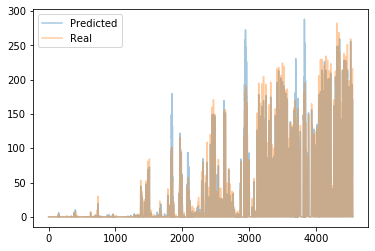

Training on dataframe: 32_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 122ms/step
MAE for the current dataframe: 17.254552083543434
MAE for the current dataframe on ['target_normalized']: 0.01440816093236208


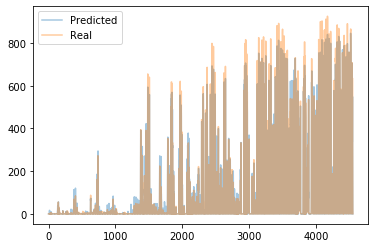

Training on dataframe: 34_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 122ms/step
MAE for the current dataframe: 7.3498991186935045
MAE for the current dataframe on ['target_normalized']: 0.011619897559285164


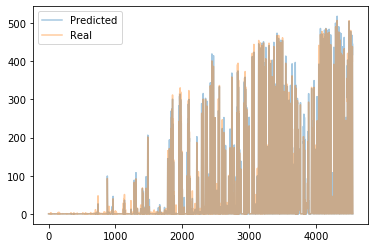

Training on dataframe: 35_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 118ms/step
MAE for the current dataframe: 20.328284521027015
MAE for the current dataframe on ['target_normalized']: 0.01090463250875473


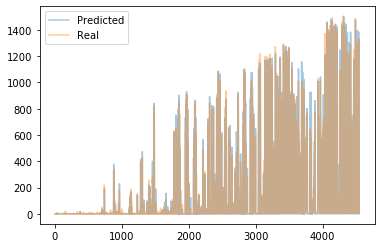

Training on dataframe: 38_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 119ms/step
MAE for the current dataframe: 8.050480593236307
MAE for the current dataframe on ['target_normalized']: 0.011782791465520859


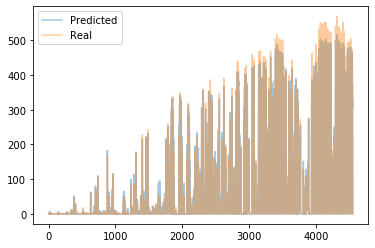

Training on dataframe: 39_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 117ms/step
MAE for the current dataframe: 25.09083161486385
MAE for the current dataframe on ['target_normalized']: 0.010164362378418446


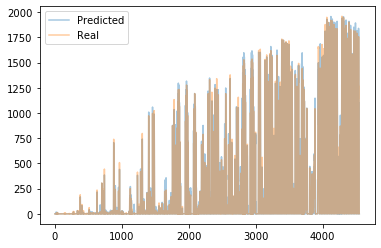

Training on dataframe: 43_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 118ms/step
MAE for the current dataframe: 18.45808308251184
MAE for the current dataframe on ['target_normalized']: 0.010649792850017548


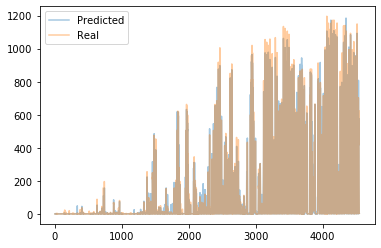

Training on dataframe: 44_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
134/134 [==============================] - 17s 124ms/step
MAE for the current dataframe: 0.25384652320882567
MAE for the current dataframe on ['target_normalized']: 0.009265251457691193


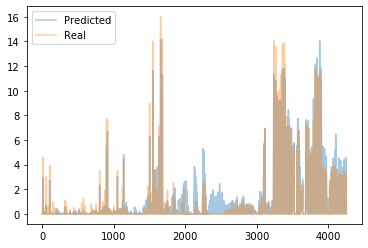

Training on dataframe: 45_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 18s 123ms/step
MAE for the current dataframe: 81.50948202231883
MAE for the current dataframe on ['target_normalized']: 0.010883783921599388


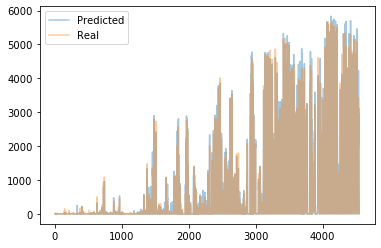

Training on dataframe: 50_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 119ms/step
MAE for the current dataframe: 1.8942584539765686
MAE for the current dataframe on ['target_normalized']: 0.010615897364914417


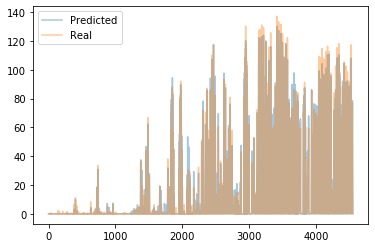

Training on dataframe: 51_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 119ms/step
MAE for the current dataframe: 12.682419054307491
MAE for the current dataframe on ['target_normalized']: 0.011995216831564903


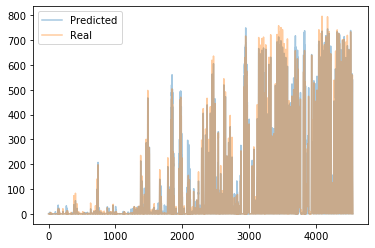

Training on dataframe: 53_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 117ms/step
MAE for the current dataframe: 5.732587167778257
MAE for the current dataframe on ['target_normalized']: 0.010889736004173756


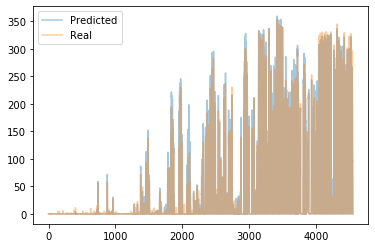

Training on dataframe: 54_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 114ms/step
MAE for the current dataframe: 26.79768768624918
MAE for the current dataframe on ['target_normalized']: 0.010293436236679554


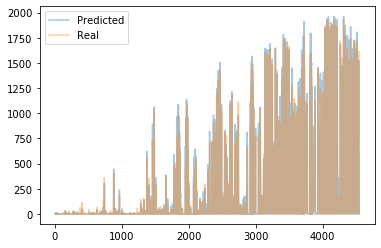

Training on dataframe: 57_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 113ms/step
MAE for the current dataframe: 3.7662868491145285
MAE for the current dataframe on ['target_normalized']: 0.009622468613088131


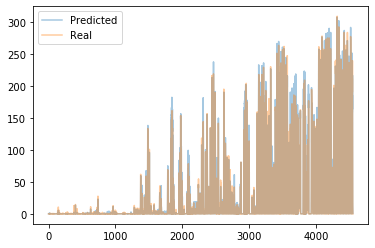

Training on dataframe: 58_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 114ms/step
MAE for the current dataframe: 17.632607044142407
MAE for the current dataframe on ['target_normalized']: 0.01052786409854889


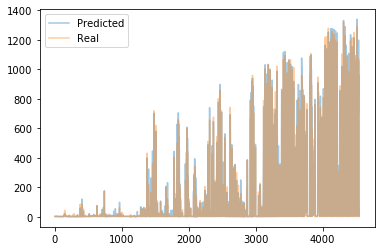

Training on dataframe: 62_c0_b0
Scaling data.
Creating the datacube.
Fitting the model
137/137 [==============================] - 16s 115ms/step
MAE for the current dataframe: 3.2440594275392107
MAE for the current dataframe on ['target_normalized']: 0.010325242765247822


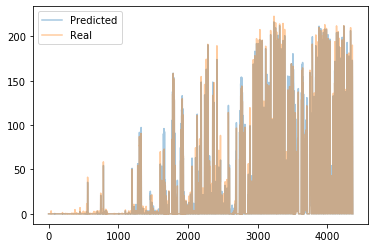

Training on dataframe: 0_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 116ms/step
MAE for the current dataframe: 52.96805387680032
MAE for the current dataframe on ['target_normalized']: 0.01150764524936676


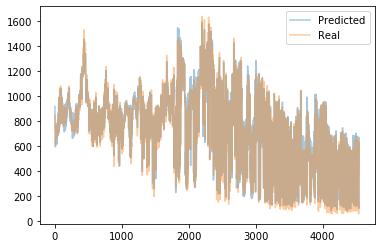

Training on dataframe: 1_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 20s 137ms/step
MAE for the current dataframe: 2.5170529279665415
MAE for the current dataframe on ['target_normalized']: 0.028141822665929794


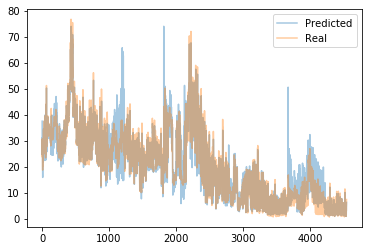

Training on dataframe: 2_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 19s 135ms/step
MAE for the current dataframe: 123.69412184984178
MAE for the current dataframe on ['target_normalized']: 0.008805469609797001


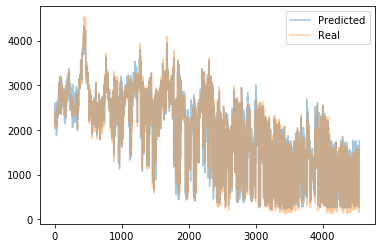

Training on dataframe: 6_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 116ms/step
MAE for the current dataframe: 2.176919344493909
MAE for the current dataframe on ['target_normalized']: 0.01774502731859684


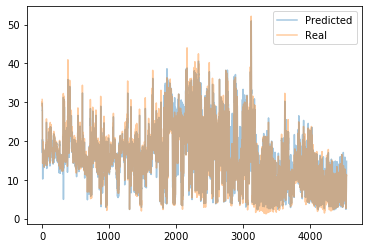

Training on dataframe: 7_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 115ms/step
MAE for the current dataframe: 5.415979195745545
MAE for the current dataframe on ['target_normalized']: 0.008514616638422012


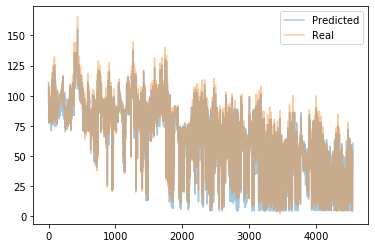

Training on dataframe: 9_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 114ms/step
MAE for the current dataframe: 6.692104263607124
MAE for the current dataframe on ['target_normalized']: 0.00883473176509142


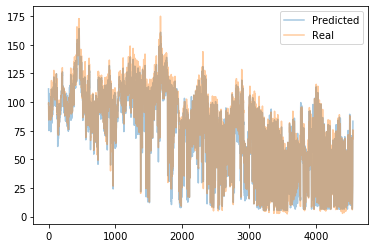

Training on dataframe: 11_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 112ms/step
MAE for the current dataframe: 4.009136766517114
MAE for the current dataframe on ['target_normalized']: 0.010622438974678516


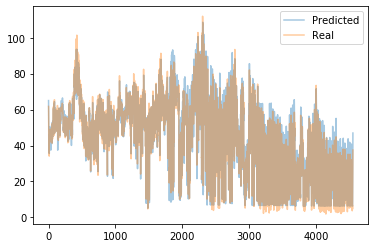

Training on dataframe: 12_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 115ms/step
MAE for the current dataframe: 10.607303672290088
MAE for the current dataframe on ['target_normalized']: 0.007070961408317089


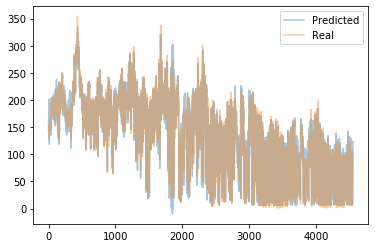

Training on dataframe: 15_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 120ms/step
MAE for the current dataframe: 2.814418407466018
MAE for the current dataframe on ['target_normalized']: 0.007738110609352589


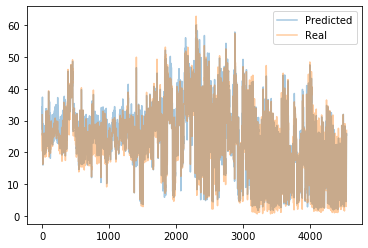

Training on dataframe: 16_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 121ms/step
MAE for the current dataframe: 6.358206345127695
MAE for the current dataframe on ['target_normalized']: 0.0053596505895257


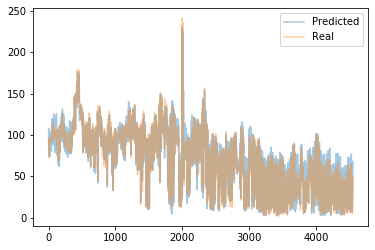

Training on dataframe: 19_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 116ms/step
MAE for the current dataframe: 5.172250992527185
MAE for the current dataframe on ['target_normalized']: 0.008954424411058426


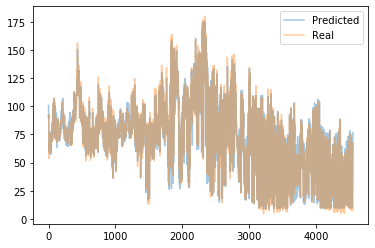

Training on dataframe: 20_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 16s 113ms/step
MAE for the current dataframe: 16.185592788191798
MAE for the current dataframe on ['target_normalized']: 0.007064168341457844


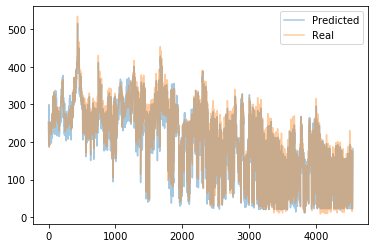

Training on dataframe: 25_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 20s 142ms/step
MAE for the current dataframe: 8.458402250954473
MAE for the current dataframe on ['target_normalized']: 0.007280639372766018


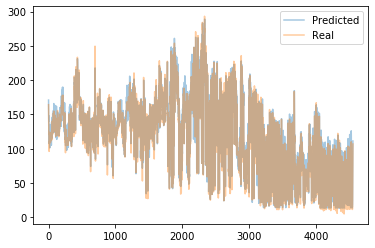

Training on dataframe: 26_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
100/100 [==============================] - 17s 166ms/step
MAE for the current dataframe: 1.3670548404429415
MAE for the current dataframe on ['target_normalized']: 0.03040917217731476


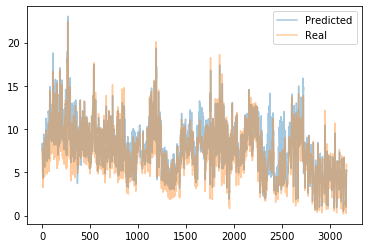

Training on dataframe: 27_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 21s 145ms/step
MAE for the current dataframe: 21.227987857995068
MAE for the current dataframe on ['target_normalized']: 0.006112189963459969


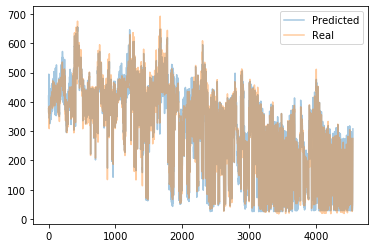

Training on dataframe: 31_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 24s 165ms/step
MAE for the current dataframe: 4.702254702664493
MAE for the current dataframe on ['target_normalized']: 0.007416606415063143


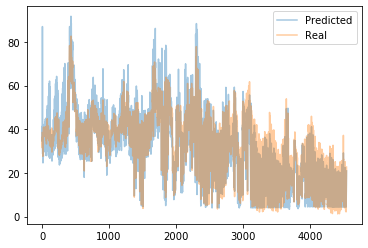

Training on dataframe: 32_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 21s 145ms/step
MAE for the current dataframe: 8.195129669593216
MAE for the current dataframe on ['target_normalized']: 0.0069536431692540646


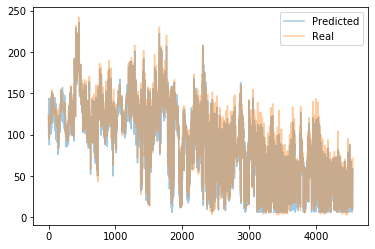

Training on dataframe: 34_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 20s 142ms/step
MAE for the current dataframe: 6.050409553973909
MAE for the current dataframe on ['target_normalized']: 0.010674930177628994


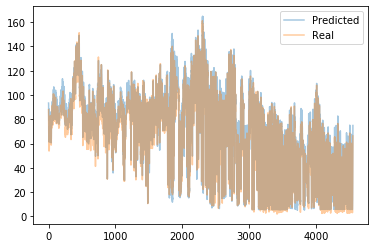

Training on dataframe: 35_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 19s 131ms/step
MAE for the current dataframe: 11.836529734394992
MAE for the current dataframe on ['target_normalized']: 0.0065117585472762585


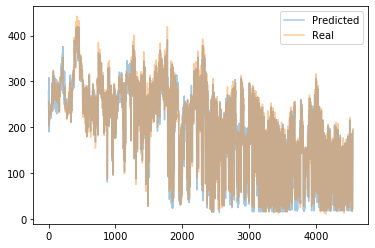

Training on dataframe: 38_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 22s 151ms/step
MAE for the current dataframe: 4.321642040465685
MAE for the current dataframe on ['target_normalized']: 0.006838785018771887


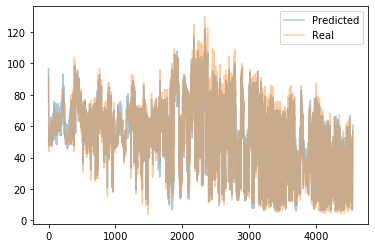

Training on dataframe: 39_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 22s 154ms/step
MAE for the current dataframe: 14.675492502026732
MAE for the current dataframe on ['target_normalized']: 0.0061138528399169445


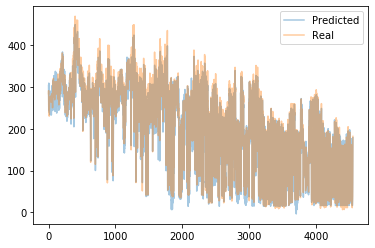

Training on dataframe: 43_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 121ms/step
MAE for the current dataframe: 12.28013053567883
MAE for the current dataframe on ['target_normalized']: 0.0076828934252262115


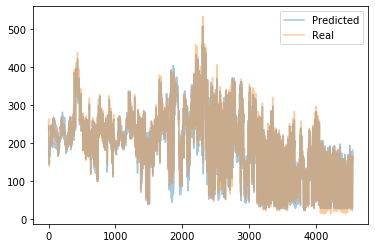

Training on dataframe: 44_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
134/134 [==============================] - 17s 125ms/step
MAE for the current dataframe: 1.3069775480530021
MAE for the current dataframe on ['target_normalized']: 0.038353197276592255


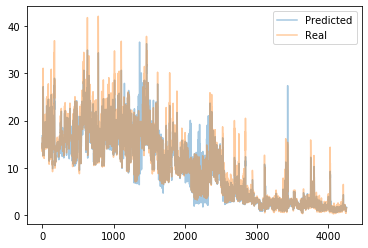

Training on dataframe: 45_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 18s 129ms/step
MAE for the current dataframe: 49.38835738764352
MAE for the current dataframe on ['target_normalized']: 0.007029695436358452


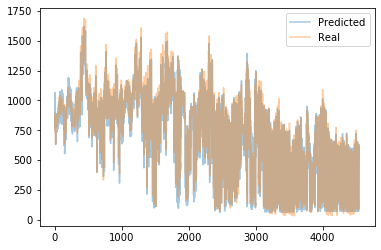

Training on dataframe: 50_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 18s 124ms/step
MAE for the current dataframe: 1.8477112679907197
MAE for the current dataframe on ['target_normalized']: 0.010928867384791374


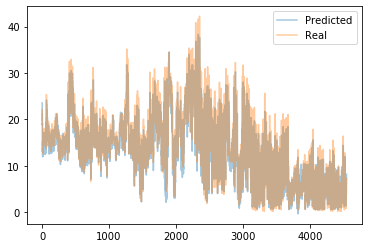

Training on dataframe: 51_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 121ms/step
MAE for the current dataframe: 7.819939871892135
MAE for the current dataframe on ['target_normalized']: 0.007669795770198107


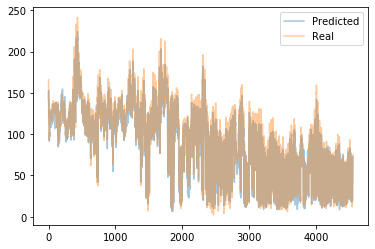

Training on dataframe: 53_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 121ms/step
MAE for the current dataframe: 3.490465849410709
MAE for the current dataframe on ['target_normalized']: 0.007333096582442522


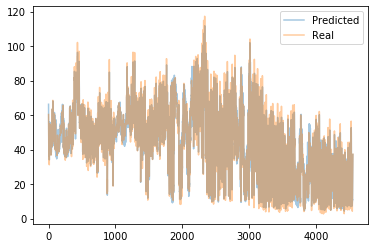

Training on dataframe: 54_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 119ms/step
MAE for the current dataframe: 15.345811585384489
MAE for the current dataframe on ['target_normalized']: 0.006034316960722208


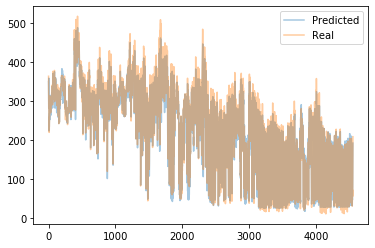

Training on dataframe: 57_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 118ms/step
MAE for the current dataframe: 4.296954257544738
MAE for the current dataframe on ['target_normalized']: 0.01215775404125452


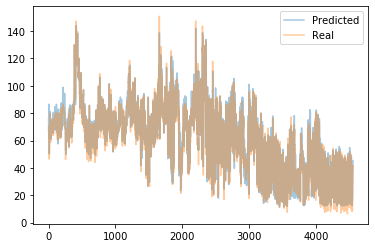

Training on dataframe: 58_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
143/143 [==============================] - 17s 118ms/step
MAE for the current dataframe: 8.878773843339108
MAE for the current dataframe on ['target_normalized']: 0.005578045733273029


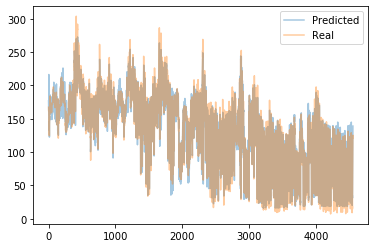

Training on dataframe: 62_c1_b0
Scaling data.
Creating the datacube.
Fitting the model
137/137 [==============================] - 16s 119ms/step
MAE for the current dataframe: 2.880750551439069
MAE for the current dataframe on ['target_normalized']: 0.009999105706810951


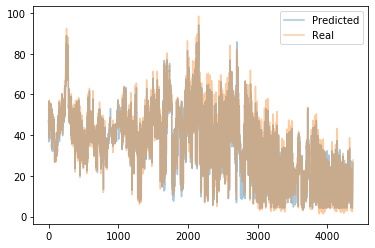

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2024-01-03 17:30:20         3372
metadata.json                                  2024-01-03 17:30:20           64

ValueError: No objects to concatenate

In [48]:
# Sampling function
def sample_dataframe(df, step=2500, count=500):
    # Calculate the total number of samples to take
    total_samples = min(len(df), step * ((len(df) - 1) // step + 1))
    
    # Generate sample indices
    indices = [i for j in range(0, total_samples, step) for i in range(j, min(j + count, len(df)))]
    
    # Return sampled DataFrame
    return df.iloc[indices]

  
lstm_output=['target_normalized']
batch_size=32
epochs=1
sampling_step=4000
T=24*3
models={}


for is_consumption in ['1','0']:
    filtered_cons = {key: value for key, value in df_dict.items() if 'c{}'.format(is_consumption) in key}
    input_columns=lstm_inputs[is_consumption]
    
    for is_business in ['0','1']:

        filtered_items = {key: value for key, value in filtered_cons.items() if 'b{}'.format(is_business) in key}
        sampled_dict = {key: sample_dataframe(df) for key, df in filtered_items.items()}

        # Combine all dataframes for scaling
        combined_df = pd.concat([df for df in sampled_dict.values()], axis=0) 
        print(np.shape(combined_df))

        # Drop all NaN columns from the combined dataframe
        combined_df = combined_df.dropna(axis=1, how='all')
        input_columns = [col for col in input_columns if col in combined_df.columns]
        #input_columns=input_columns+lstm_output #in order to use the target as input up to time t-1. Managed in create lstm input. 
        print(input_columns)
        # Fit the scaler on the entire dataset
        #scaler = StandardScaler()
        scaler=MinMaxScaler()
        combined_df[input_columns+lstm_output] = scaler.fit_transform(combined_df[input_columns+lstm_output])


        # Initialize the LSTM model
        model=initialize_model(input_columns+lstm_output,lstm_output,150,90,T+1) #as the transformation is done, we need here T+1.


        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        print('Starting training')
        maes=[]
        # Iterate over each dataframe in the dictionary for training
        for key, df in df_dict.items():
            print(f'Training on dataframe: {key}')

            # Apply the transformation with the fitted scaler
            temp_df=df
            df=df.dropna()
            
            #df=df[all_cols]
            df_output=df[lstm_output]
            print('Scaling data.')
            train_test = scaler.transform(df[input_columns+lstm_output].fillna(method='ffill'))
            train_test_df=pd.DataFrame(train_test,index=df.index,columns=input_columns+lstm_output)
            
            split_point = int(len(train_test_df) * 0.8)
            # Prepare input and output data
            train_features = train_test_df.iloc[:split_point]
            test_features = train_test_df.iloc[split_point:]
            
            #real not scaled
            y_real_train=df[lstm_output].iloc[:split_point]
            y_real_test=df[lstm_output].iloc[split_point:]
            
            installed_capacity_train=df['installed_capacity'].iloc[:split_point]
            installed_capacity_val=df['installed_capacity'].iloc[split_point:]
            
            print('Creating the datacube.')
            X_train,y_train,IC_train = create_in_and_out_optimized(train_features,T,y_real_train,input_columns,lstm_output,installed_capacity_train)
            X_val,y_val,IC_val = create_in_and_out_optimized(test_features,T,y_real_test,input_columns,lstm_output,installed_capacity_val)

            
            # Train the model on the data from the current dataframe
            print('Fitting the model')
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)
            #grid_result = grid.fit(X_train, y_train)
            # Print the MAE for the last epoch
            last_mae = history.history['val_loss'][-1]
            y_pred=model.predict(X_val)
            
            # Step 1: Multiply by i
            real_values = y_val * IC_val
            predicted_values = y_pred.reshape(np.shape(y_pred)[0]) * IC_val

            # Step 2: Calculate absolute differences
            absolute_differences = abs(real_values - predicted_values)

            # Step 3: Compute the mean
            mae = absolute_differences.mean()
            maes=maes+[mae]
            print("MAE for the current dataframe:", mae)
            print(f"MAE for the current dataframe on {lstm_output}: {last_mae}")
            
            plt.plot(predicted_values, alpha=0.4,label='Predicted')
            plt.plot(real_values, alpha=0.4,label='Real')
            plt.legend()
            plt.show()
        print('Trained the model. Mean MAE: {}'.format(np.mean(maes)))
        model_dict={}
        model_dict['inputs']=input_columns
        model_dict['output']=lstm_output
        model_dict['model']=model
        model_dict['scaler']=scaler
        model_dict['maes']=maes
        model_dict['mae']=np.mean(maes)
        model_dict['T']=T
        joblib.dump(model_dict, "./model_dict_c{}_b{}_{}.pkl".format(is_consumption,is_business,save_id))

    print('Training completed.')

###the datacube creation in quite long. Using the optimized version in much faster!



In [22]:
np.shape(y_real_test)

(4620, 1)

In [61]:
print(df_scanned.groupby('cluster_label').mean().index)

Int64Index([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,
            ...
            549, 550, 551, 552, 553, 554, 555, 556, 557, 558],
           dtype='int64', name='cluster_label', length=560)


<ipython-input-61-8d9c95976ed4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df_scanned.groupby('cluster_label').mean().index)


In [11]:
df_dict['0_0']['datetime']

0       2021-09-01 03:00:00
1       2021-09-01 04:00:00
2       2021-09-01 05:00:00
3       2021-09-01 06:00:00
4       2021-09-01 07:00:00
                ...        
23172   2023-05-29 19:00:00
23173   2023-05-29 20:00:00
23174   2023-05-29 21:00:00
23175   2023-05-29 22:00:00
23176   2023-05-29 23:00:00
Name: datetime, Length: 23177, dtype: datetime64[ns]

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-01-03 17:30:20         3372
metadata.json                                  2024-01-03 17:30:20           64
variables.h5                                   2024-01-03 17:30:20      3618800
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
...

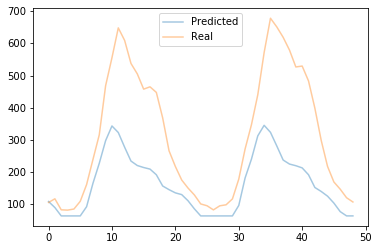

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 38ms/step
0.03923724212508465
Real is: 0.03170588235294118; prediction is: 0.053619325160980225
0.053619325160980225
1/1 [==============================] - 0s 38ms/step
0.018538273904450005
Real is: 0.04058823529411765; prediction is: 0.03014008328318596
0.03014008328318596
1/1 [==============================] - 0s 40ms/step
0.0005198557400321411
Real is: 0.02944117647058823; prediction is: 0.01746247708797455
0.01746247708797455
1/1 [==============================] - 0s 49ms/step
0.00027742301511330606
Real is: 0.05973529411764706; prediction is: 0.013894779607653618
0.013894779607653618
1/1 [==============================] - 0s 47ms/step
0.0012896421243105039
Real is: 0.03626470588235294; prediction is: 0.013833397999405861
0.013833397999405861
1/1 [==============================] - 0s 41ms/step
0.002631769683912714
Real is: 0.032911764705882356; prediction is: 0.016351835802197456
0.016351835802197456
1

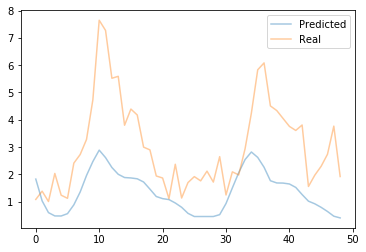

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 109ms/step
0.008944781092997718
Real is: 0.014329972786833534; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 53ms/step
0.008364766752155122
Real is: 0.020570788030212374; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 45ms/step
0.0005198557400321411
Real is: 0.015469070371195602; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.00027742301511330606
Real is: 0.014784047126094347; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 43ms/step
0.0012896421243105039
Real is: 0.018413324687874745; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 46ms/step
0.002631769683912714
Real is: 0.02031555506598004; prediction is: 0.012889811769127846
0.0128898117

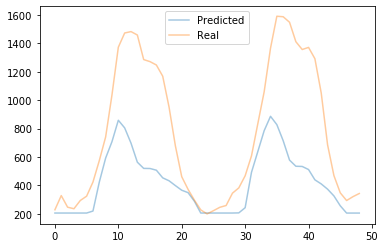

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 37ms/step
0.022021507176166664
Real is: 0.032071713147410356; prediction is: 0.0265329759567976
0.0265329759567976
1/1 [==============================] - 0s 37ms/step
0.018752465984001418
Real is: 0.02351735913488901; prediction is: 0.022828098386526108
0.022828098386526108
1/1 [==============================] - 0s 39ms/step
0.0005198557400321411
Real is: 0.028099032441661922; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 42ms/step
0.00027742301511330606
Real is: 0.030671599317017642; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 40ms/step
0.0012896421243105039
Real is: 0.01911212293682413; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.002631769683912714
Real is: 0.03959021058622652; prediction is: 0.012889811769127846
0.01288981176912784

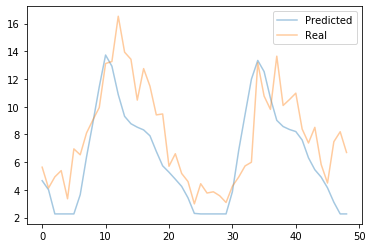

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 68ms/step
0.008083306628782904
Real is: 0.008732485102270895; prediction is: 0.019098322838544846
0.019098322838544846
1/1 [==============================] - 0s 41ms/step
0.005087466028579997
Real is: 0.010185215010468672; prediction is: 0.01512545719742775
0.01512545719742775
1/1 [==============================] - 0s 49ms/step
0.0005198557400321411
Real is: 0.009740698985343854; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 43ms/step
0.00027742301511330606
Real is: 0.007099371879529715; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 38ms/step
0.0012896421243105039
Real is: 0.008085037848284746; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 39ms/step
0.002631769683912714
Real is: 0.012955387340956675; prediction is: 0.014069435186684132
0.014069435186

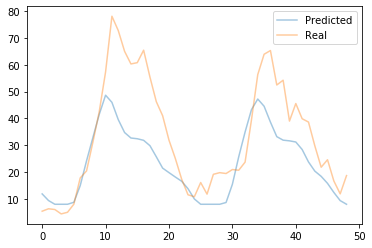

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 49ms/step
0.0059681180882038675
Real is: 0.013848382423949783; prediction is: 0.014170113019645214
0.014170113019645214
1/1 [==============================] - 0s 50ms/step
0.008082798030884224
Real is: 0.01733354793712109; prediction is: 0.015500481240451336
0.015500481240451336
1/1 [==============================] - 0s 37ms/step
0.0005198557400321411
Real is: 0.016748752615483663; prediction is: 0.01408933475613594
0.01408933475613594
1/1 [==============================] - 0s 43ms/step
0.00027742301511330606
Real is: 0.02081442137453726; prediction is: 0.013589802198112011
0.013589802198112011
1/1 [==============================] - 0s 45ms/step
0.0012896421243105039
Real is: 0.047999356188636724; prediction is: 0.015507274307310581
0.015507274307310581
1/1 [==============================] - 0s 56ms/step
0.002631769683912714
Real is: 0.032795750845002414; prediction is: 0.021272294223308563
0.0212722942233

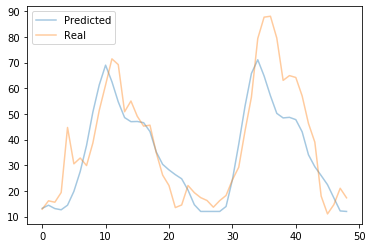

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 63ms/step
0.00934672646116121
Real is: 0.007544483985765125; prediction is: 0.015897931531071663
0.015897931531071663
1/1 [==============================] - 0s 40ms/step
0.0043918973845488265
Real is: 0.00798576512455516; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 44ms/step
0.0005198557400321411
Real is: 0.02316014234875445; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 39ms/step
0.00027742301511330606
Real is: 0.017897983392645315; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 42ms/step
0.0012896421243105039
Real is: 0.016621589561091343; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 42ms/step
0.002631769683912714
Real is: 0.013637010676156584; prediction is: 0.013189137913286686
0.013189137913

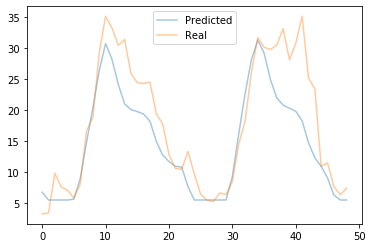

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 47ms/step
0.004985359147183848
Real is: 0.00407143680986809; prediction is: 0.014715851284563541
0.014715851284563541
1/1 [==============================] - 0s 38ms/step
0.0023584458319944497
Real is: 0.01532054900960949; prediction is: 0.013242373242974281
0.013242373242974281
1/1 [==============================] - 0s 46ms/step
0.0005198557400321411
Real is: 0.025928016851511238; prediction is: 0.012975768186151981
0.012975768186151981
1/1 [==============================] - 0s 40ms/step
0.00027742301511330606
Real is: 0.016625691270115886; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 47ms/step
0.0012896421243105039
Real is: 0.009429804592886672; prediction is: 0.014143522828817368
0.014143522828817368
1/1 [==============================] - 0s 51ms/step
0.002631769683912714
Real is: 0.010598362198223793; prediction is: 0.01563260518014431
0.015632605180

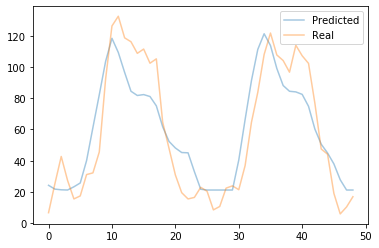

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 57ms/step
0.002458707611810775
Real is: 0.007259321676848535; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 42ms/step
0.004224936295214743
Real is: 0.00510848957236149; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 45ms/step
0.0005198557400321411
Real is: 0.007838634927322518; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 48ms/step
0.00027742301511330606
Real is: 0.02692016010111649; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.0012896421243105039
Real is: 0.026985464503897192; prediction is: 0.013194822706282139
0.013194822706282139
1/1 [==============================] - 0s 47ms/step
0.002631769683912714
Real is: 0.03134821992837581; prediction is: 0.014873389154672623
0.0148733891546

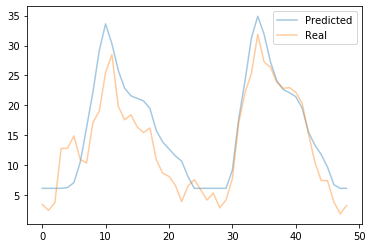

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 43ms/step
0.002020471099233695
Real is: 0.005303300306507948; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 40ms/step
0.0030796956777096596
Real is: 0.006993370874616865; prediction is: 0.013754131272435188
0.013754131272435188
1/1 [==============================] - 0s 41ms/step
0.0005198557400321411
Real is: 0.004946182906835839; prediction is: 0.013747060671448708
0.013747060671448708
1/1 [==============================] - 0s 37ms/step
0.00027742301511330606
Real is: 0.01792572528334165; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 37ms/step
0.0012896421243105039
Real is: 0.014858507377575022; prediction is: 0.01555567979812622
0.01555567979812622
1/1 [==============================] - 0s 36ms/step
0.002631769683912714
Real is: 0.012528334164944045; prediction is: 0.01715664379298687
0.0171566437929

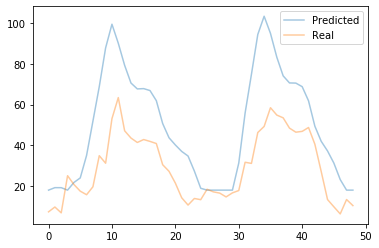

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 68ms/step
0.016342219120875103
Real is: 0.022540971504503172; prediction is: 0.01689981482923031
0.01689981482923031
1/1 [==============================] - 0s 43ms/step
0.013172264964774368
Real is: 0.016375313745755203; prediction is: 0.014831876382231712
0.014831876382231712
1/1 [==============================] - 0s 37ms/step
0.0005198557400321411
Real is: 0.018079137752842166; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 42ms/step
0.00027742301511330606
Real is: 0.033485899896648456; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.0012896421243105039
Real is: 0.018083567104680346; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 44ms/step
0.002631769683912714
Real is: 0.019162852502583785; prediction is: 0.012889811769127846
0.012889811769

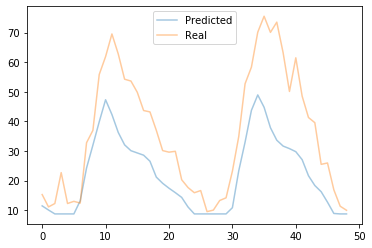

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 38ms/step
0.010621169301498408
Real is: 0.014009071945458744; prediction is: 0.014693884178996086
0.014693884178996086
1/1 [==============================] - 0s 45ms/step
0.008176880932855523
Real is: 0.012026785329904937; prediction is: 0.012942778877913952
0.012942778877913952
1/1 [==============================] - 0s 41ms/step
0.0005198557400321411
Real is: 0.0172222156993969; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 72ms/step
0.00027742301511330606
Real is: 0.027063985002720017; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 67ms/step
0.0012896421243105039
Real is: 0.01684650096081217; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.002631769683912714
Real is: 0.01819242073788809; prediction is: 0.013796456158161163
0.01379645615816

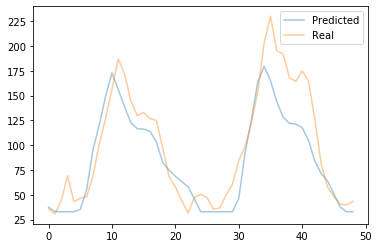

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 54ms/step
0.00823548011159782
Real is: 0.011086560853289249; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 43ms/step
0.006465765472353749
Real is: 0.009135345218130806; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.0005198557400321411
Real is: 0.009233104698018583; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 45ms/step
0.00027742301511330606
Real is: 0.010852891852581882; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.0012896421243105039
Real is: 0.015208354858964069; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 43ms/step
0.002631769683912714
Real is: 0.014015371287325443; prediction is: 0.012889811769127846
0.01288981176

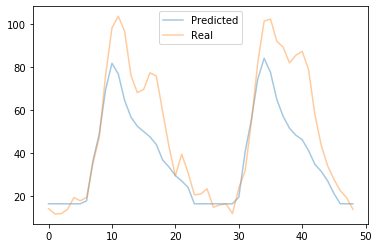

finished!
saved
Creating the datacube.
--------- Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by MinMaxScaler.
Creating the datacube.
1/1 [==============================] - 0s 43ms/step
0.004301969221253132
Real is: 0.006060309305531492; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 39ms/step
0.0035229206171936657
Real is: 0.0053308625049278465; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 40ms/step
0.0005198557400321411
Real is: 0.007618889784480486; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 43ms/step
0.00027742301511330606
Real is: 0.008661961044276544; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 45ms/step
0.0012896421243105039
Real is: 0.01187253136872343; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==================

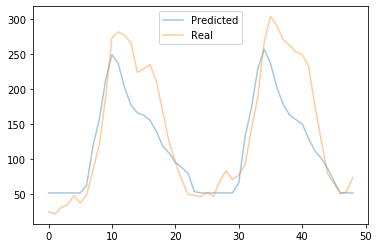

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 38ms/step
0.0029172790099737025
Real is: 0.004323882224645584; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 47ms/step
0.0025062513453134394
Real is: 0.005928298800436205; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 51ms/step
0.0005198557400321411
Real is: 0.0055561613958560515; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.00027742301511330606
Real is: 0.008874045801526717; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 47ms/step
0.0012896421243105039
Real is: 0.009101690294438386; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 66ms/step
0.002631769683912714
Real is: 0.01508587786259542; prediction is: 0.012924613431096077
0.01292461

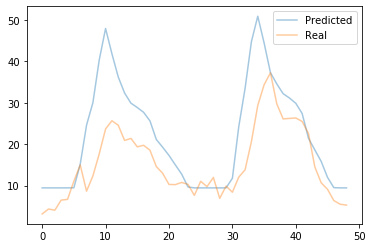

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 49ms/step
0.003477742728071684
Real is: 0.002387447739269399; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 55ms/step
0.0013724787498718
Real is: 0.003618298923307882; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 80ms/step
0.0005198557400321411
Real is: 0.00945858690212917; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 62ms/step
0.00027742301511330606
Real is: 0.011531259584496925; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 54ms/step
0.0012896421243105039
Real is: 0.011181778559783046; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 52ms/step
0.002631769683912714
Real is: 0.02378165910668453; prediction is: 0.01344618946313858
0.013446189463138

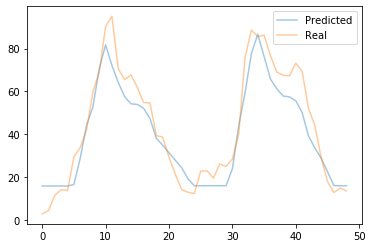

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 45ms/step
0.002316441789679432
Real is: 0.009018712916476494; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 47ms/step
0.005255050965870776
Real is: 0.016563213144682794; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 59ms/step
0.0005198557400321411
Real is: 0.012458542522440285; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 67ms/step
0.00027742301511330606
Real is: 0.011559409706374561; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 63ms/step
0.0012896421243105039
Real is: 0.012027993305948576; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 62ms/step
0.002631769683912714
Real is: 0.01120797200669405; prediction is: 0.012889811769127846
0.01288981176

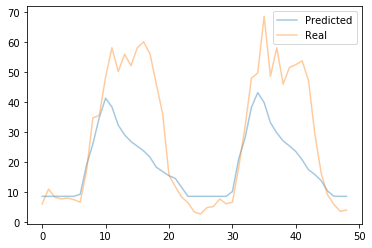

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 47ms/step
0.005707597063398302
Real is: 0.013513726416952225; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 60ms/step
0.007886858631695077
Real is: 0.022159695143566114; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 59ms/step
0.0005198557400321411
Real is: 0.020623596833274256; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 54ms/step
0.00027742301511330606
Real is: 0.014179369018078697; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 73ms/step
0.0012896421243105039
Real is: 0.01585479932254126; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 67ms/step
0.002631769683912714
Real is: 0.013622533380597898; prediction is: 0.012889811769127846
0.01288981176

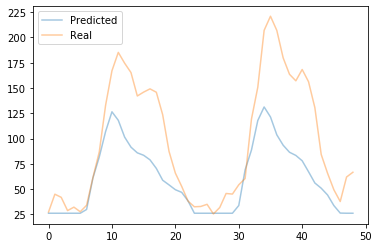

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 48ms/step
0.007255263996402237
Real is: 0.011880423236629006; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 63ms/step
0.00693056788192649
Real is: 0.01209838734152768; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 68ms/step
0.0005198557400321411
Real is: 0.008910317427471753; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 58ms/step
0.00027742301511330606
Real is: 0.007568044806798273; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 65ms/step
0.0012896421243105039
Real is: 0.014000744940611678; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 67ms/step
0.002631769683912714
Real is: 0.021132861537612607; prediction is: 0.012889811769127846
0.012889811769

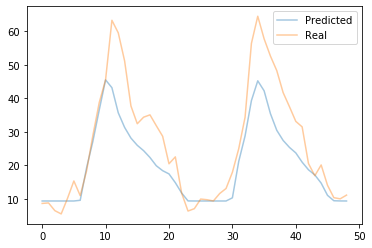

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 47ms/step
0.003795666625966806
Real is: 0.004239711781310354; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 58ms/step
0.0024569699765295545
Real is: 0.008540707175753974; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 48ms/step
0.0005198557400321411
Real is: 0.009295052741048878; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 58ms/step
0.00027742301511330606
Real is: 0.0116925419699896; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 49ms/step
0.0012896421243105039
Real is: 0.01139169514188085; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 59ms/step
0.002631769683912714
Real is: 0.010275590551181102; prediction is: 0.012889811769127846
0.012889811769

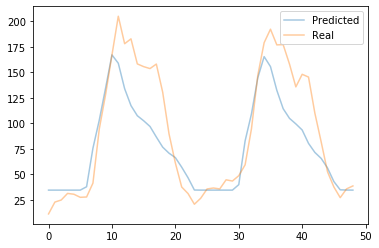

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 40ms/step
0.006043419065062189
Real is: 0.010261593341260405; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 46ms/step
0.005982751167283535
Real is: 0.009553252930185155; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 44ms/step
0.0005198557400321411
Real is: 0.010417303663439216; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 40ms/step
0.00027742301511330606
Real is: 0.014949889587226092; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 41ms/step
0.0012896421243105039
Real is: 0.018915123718928714; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 37ms/step
0.002631769683912714
Real is: 0.01700753071739992; prediction is: 0.012889811769127846
0.01288981176

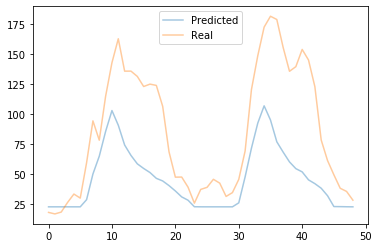

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 56ms/step
0.048928522771924596
Real is: 0.06644444444444444; prediction is: 0.03711264207959175
0.03711264207959175
1/1 [==============================] - 0s 100ms/step
0.03887752627876562
Real is: 0.08155555555555555; prediction is: 0.02959485352039337
0.02959485352039337
1/1 [==============================] - 0s 83ms/step
0.0005198557400321411
Real is: 0.07633333333333334; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 84ms/step
0.00027742301511330606
Real is: 0.06994444444444443; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 99ms/step
0.0012896421243105039
Real is: 0.07661111111111112; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 74ms/step
0.002631769683912714
Real is: 0.08833333333333333; prediction is: 0.012889811769127846
0.012889811769127846
1

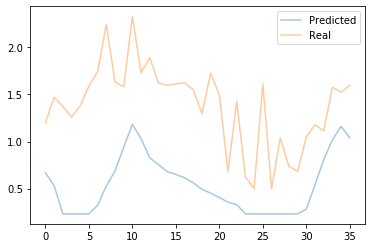

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 46ms/step
0.003463463097891566
Real is: 0.005914989365964923; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 72ms/step
0.003437836527700287
Real is: 0.009294824769595908; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 68ms/step
0.0005198557400321411
Real is: 0.014375366026569676; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 54ms/step
0.00027742301511330606
Real is: 0.018990475603365902; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 51ms/step
0.0012896421243105039
Real is: 0.02020170761027032; prediction is: 0.013053253293037415
0.013053253293037415
1/1 [==============================] - 0s 49ms/step
0.002631769683912714
Real is: 0.019632586382270445; prediction is: 0.01322387158870697
0.013223871588

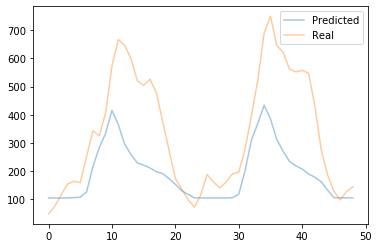

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 41ms/step
0.004314802423334307
Real is: 0.000900443880786303; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 46ms/step
0.0005018455129634039
Real is: 0.003836398224476854; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 53ms/step
0.0005198557400321411
Real is: 0.0021116043119847813; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 68ms/step
0.00027742301511330606
Real is: 0.013081800887761572; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 66ms/step
0.0012896421243105039
Real is: 0.02105897273303741; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 51ms/step
0.002631769683912714
Real is: 0.016233354470513633; prediction is: 0.013026836328208447
0.013026836

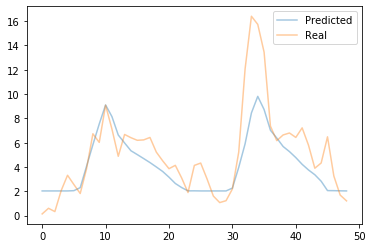

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 45ms/step
0.007536115570072425
Real is: 0.012867936612343455; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 52ms/step
0.00750875196792184
Real is: 0.017992435716573052; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 68ms/step
0.0005198557400321411
Real is: 0.017666150264403727; prediction is: 0.012965032830834389
0.012965032830834389
1/1 [==============================] - 0s 62ms/step
0.00027742301511330606
Real is: 0.020549059657443546; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 62ms/step
0.0012896421243105039
Real is: 0.020909098777078663; prediction is: 0.012901101261377335
0.012901101261377335
1/1 [==============================] - 0s 75ms/step
0.002631769683912714
Real is: 0.027112849761560632; prediction is: 0.01295844092965126
0.012958440929

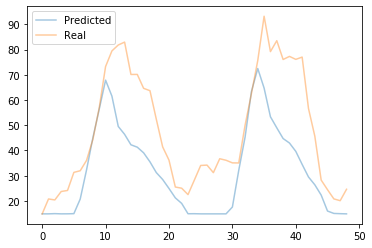

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 45ms/step
0.006058671026118665
Real is: 0.012768619662363456; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 45ms/step
0.007450602396118332
Real is: 0.010075471698113209; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 66ms/step
0.0005198557400321411
Real is: 0.017996027805362462; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 66ms/step
0.00027742301511330606
Real is: 0.016699106256206554; prediction is: 0.012902868911623955
0.012902868911623955
1/1 [==============================] - 0s 69ms/step
0.0012896421243105039
Real is: 0.02938033763654419; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 58ms/step
0.002631769683912714
Real is: 0.01808540218470705; prediction is: 0.012964235618710518
0.012964235618

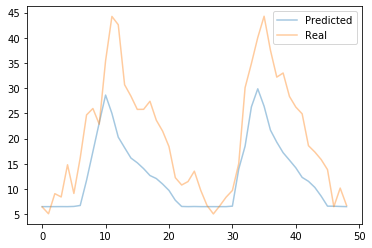

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 53ms/step
0.0037264393608108168
Real is: 0.005705049548288952; prediction is: 0.012923764064908028
0.012923764064908028
1/1 [==============================] - 0s 61ms/step
0.003314917826463261
Real is: 0.014850135262164625; prediction is: 0.012909873388707638
0.012909873388707638
1/1 [==============================] - 0s 58ms/step
0.0005198557400321411
Real is: 0.016108037514620515; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 89ms/step
0.00027742301511330606
Real is: 0.015315838948327703; prediction is: 0.012937614694237709
0.012937614694237709
1/1 [==============================] - 0s 56ms/step
0.0012896421243105039
Real is: 0.018119030704870157; prediction is: 0.012927946634590626
0.012927946634590626
1/1 [==============================] - 0s 46ms/step
0.002631769683912714
Real is: 0.030588264841165624; prediction is: 0.013079473748803139
0.013079473

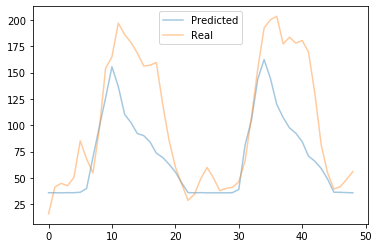

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 49ms/step
0.014779660239888
Real is: 0.020416265640038497; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 57ms/step
0.011928260429275606
Real is: 0.015257459095283926; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 81ms/step
0.0005198557400321411
Real is: 0.020442733397497595; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 85ms/step
0.00027742301511330606
Real is: 0.021746871992300288; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 64ms/step
0.0012896421243105039
Real is: 0.02771174205967276; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 108ms/step
0.002631769683912714
Real is: 0.03614533205004812; prediction is: 0.012889811769127846
0.01288981176912

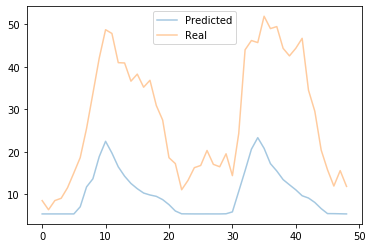

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 48ms/step
0.003335938457668885
Real is: 0.005198992443324937; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 55ms/step
0.0030186239514730763
Real is: 0.007207211984621503; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 59ms/step
0.0005198557400321411
Real is: 0.01181598833355429; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 51ms/step
0.00027742301511330606
Real is: 0.01438631844093862; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 53ms/step
0.0012896421243105039
Real is: 0.01320747713111494; prediction is: 0.012934425845742226
0.012934425845742226
1/1 [==============================] - 0s 60ms/step
0.002631769683912714
Real is: 0.01985947235847806; prediction is: 0.013270214200019836
0.0132702142000

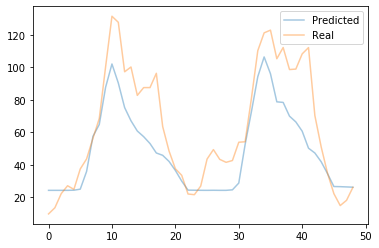

finished!
saved
Creating the datacube.
1/1 [==============================] - 0s 39ms/step
0.00723090695180026
Real is: 0.010378331094379705; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 46ms/step
0.006051100531199342
Real is: 0.011799806304476865; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 60ms/step
0.0005198557400321411
Real is: 0.008588209566059546; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 58ms/step
0.00027742301511330606
Real is: 0.018779093379986875; prediction is: 0.012889811769127846
0.012889811769127846
1/1 [==============================] - 0s 65ms/step
0.0012896421243105039
Real is: 0.03776125464713049; prediction is: 0.013411910273134708
0.013411910273134708
1/1 [==============================] - 0s 63ms/step
0.002631769683912714
Real is: 0.03894842075666219; prediction is: 0.017911236733198166
0.0179112367331

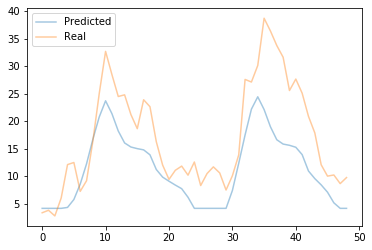

finished!
saved
FFFFFFINISSSSSH!!!!


In [68]:
#model_dicts={}
%matplotlib inline
from datetime import timedelta

we_are_at='2023-05-26 12:00:00'
starting_datetime = pd.Timestamp(we_are_at)#.tz_localize(None)
hours_of_prediction=48
datetime='datetime'
for is_consumption in ['1','0']:
     #is_consumption='1'
    filtered_items = {key: value for key, value in df_dict.items() if 'c{}'.format(is_consumption) in key}
    #input_columns=lstm_inputs[is_consumption]

    for is_business in ['0','1']:
        #is_business='0'
        filtered_dict = {key: value for key, value in filtered_items.items() if 'b{}'.format(is_business) in key}

        model_dict=joblib.load("./model_dict_c{}_b{}_{}.pkl".format(is_consumption,is_business,save_id))
        #model_dicts[item]=model_dict
        puis=filtered_dict.keys()
        pred_dict={}
        #model_dict=model_dicts[item]
        model=model_dict['model']
        scaler=model_dict['scaler']
        lstm_input=model_dict['inputs']
        lstm_output=model_dict['output']
        T=model_dict['T']
        maes=[]
        dict_pred={}
        for pui in puis:
            try:
                df=filtered_dict[pui]
                
                
                try:
                    df=df.set_index(datetime)
                except Exception as e:
                    #print(df.index) 
                    print(e)
                df.index=pd.to_datetime(df.index)
                df=df.sort_index()
                end_prediction=starting_datetime+timedelta(hours=hours_of_prediction) #represents the period of prediction
                first_hour=starting_datetime-timedelta(hours=T+1)
                df_temp=df.loc[first_hour:end_prediction]
                
                
                ###
                y_real_original=df_temp[lstm_output]
                
                installed_capacity_original=df_temp['installed_capacity']
                
                print('Creating the datacube.')

                
                ###
                #transform all
                #df_scaled=pd.DataFrame(scaler.transform(df_temp[lstm_input+lstm_output].fillna(method='ffill')),\
                #   index=df_temp.index,columns=lstm_input+lstm_output)
                #nopes,y_real,IC = create_in_and_out_optimized(train_features,T,y_real_original,input_columns,lstm_output,installed_capacity_original)


                #impose nan after starting date
                df_temp.loc[df_temp.index >= starting_datetime, lstm_output]=np.nan
                
                #scale again
                df_scaled=pd.DataFrame(scaler.transform(df_temp[lstm_input+lstm_output]),\
                    index=df_temp.index,columns=lstm_input+lstm_output)
                X,y_real,IC = create_in_and_out_optimized(df_scaled,T,y_real_original,input_columns,lstm_output,installed_capacity_original)

                
                hours=[]
                pred=[]
                target=[]
                N=np.shape(X)[0]
                Y_pred=np.zeros(N)
                for row in range(N):
                    #print('Doing row {}'.format(row))
                    x=X[row,:,:] #this x has at t+T,-1 the value of y at t, -1.

                    #ffill array x
                    mask = np.isnan(x)
                    idx = np.where(~mask,np.arange(mask.shape[1]),0)
                    np.maximum.accumulate(idx,axis=1, out=idx)
                    x[mask] = x[np.nonzero(mask)[0], idx[mask]]
                    
                    
                    y=model.predict(x.reshape(-1,np.shape(x)[0],np.shape(x)[1]))
                    '''
                    plt.plot(x,alpha=0.4)
                    plt.plot(y_real,label='Real')
                    plt.plot(Y_pred,label='Prediction')
                    plt.legend()
                    plt.show()
                    '''
                    print(X[row,-1,-1])
                    if y.item()==np.nan:
                        X[row,-1,-1]=0
                    else:
                        X[row,-1,-1]=y.item()
                    print('Real is: {}; prediction is: {}'.format(y_real[row],y.item()))
                    print(X[row,-1,-1])
                    Y_pred[row]=y.item()
                #dict_pred[pui]['prediction']=Y_pred
                #dict_pred[pui]['real']=y_real
                #plt.plot(y_very_real.values,alpha=0.6,label='Real, not scaled')
                # Step 1: Multiply by i
                real_values = y_real * IC
                predicted_values = Y_pred.reshape(np.shape(Y_pred)[0]) * IC

                # Step 2: Calculate absolute differences
                absolute_differences = abs(real_values - predicted_values)

                # Step 3: Compute the mean
                mae = absolute_differences.mean()
                print("MAE for the current dataframe:", mae)
                maes=maes+[mae]
                print('---> Mean MAE since now is : {} <---'.format(np.mean(maes)))
                plt.plot(predicted_values, alpha=0.4,label='Predicted')
                plt.plot(real_values, alpha=0.4,label='Real')
                plt.legend()
                plt.show()

                
                #final_dict[pui]=df
                print('finished!')
                #joblib.dump(final_dict, "./test_dataset_{}_{}.pkl".format(item,save_id))

                print('saved')
            except Exception as e: 
                print('--------- {}'.format(e))
                continue
print('FFFFFFINISSSSSH!!!!')


In [65]:
y_real_original

,target_normalized
datetime,
2023-05-23 11:00:00,0.015826
2023-05-23 12:00:00,0.016202
2023-05-23 13:00:00,0.020748
2023-05-23 14:00:00,0.028388
2023-05-23 15:00:00,0.022457
...,...
2023-05-28 08:00:00,0.034108
2023-05-28 09:00:00,0.029594
2023-05-28 10:00:00,0.024254


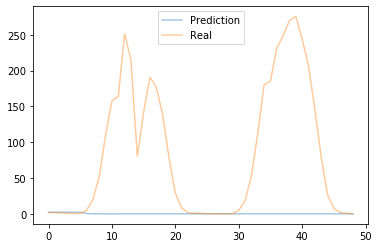

In [25]:
plt.plot(Y_pred,alpha=0.4,label='Prediction')
plt.plot(y_real,alpha=0.4,label='Real')
plt.legend()
plt.show()

In [34]:
for row in range(N):
    print(Y_pred[row])
    display(X[row,:,-1])

0.2905319333076477


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.68000000e-01, 6.64000000e-01,
       2.58500000e+00, 6.55700000e+00, 1.37480000e+01, 1.83270000e+01,
       1.93200000e+01, 1.48490000e+01, 1.14100000e+01, 6.85000000e+00,
       1.02380000e+01, 1.08280000e+01, 9.93000000e+00, 5.01800000e+00,
       1.64300000e+00, 2.21000000e-01, 2.90000000e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.65000000e-01, 1.03800000e+00,
       2.89100000e+00, 7.14300000e+00, 1.25500000e+01, 1.77650000e+01,
       1.93190000e+01, 1.35310000e+01, 1.59820000e+01, 1.61320000e+01,
       1.00850000e+01, 1.02570000e+01, 8.86200000e+00, 4.82900000e+00,
       2.18400000e+00, 4.30000000e-01, 1.60000000e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.09000000e-01, 1.20900000e+00,
      

0.8453007936477661


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.68000000e-01, 6.64000000e-01, 2.58500000e+00,
       6.55700000e+00, 1.37480000e+01, 1.83270000e+01, 1.93200000e+01,
       1.48490000e+01, 1.14100000e+01, 6.85000000e+00, 1.02380000e+01,
       1.08280000e+01, 9.93000000e+00, 5.01800000e+00, 1.64300000e+00,
       2.21000000e-01, 2.90000000e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.65000000e-01, 1.03800000e+00, 2.89100000e+00,
       7.14300000e+00, 1.25500000e+01, 1.77650000e+01, 1.93190000e+01,
       1.35310000e+01, 1.59820000e+01, 1.61320000e+01, 1.00850000e+01,
       1.02570000e+01, 8.86200000e+00, 4.82900000e+00, 2.18400000e+00,
       4.30000000e-01, 1.60000000e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.09000000e-01, 1.20900000e+00, 3.11700000e+00,
      

0.7955794334411621


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.68000000e-01, 6.64000000e-01, 2.58500000e+00, 6.55700000e+00,
       1.37480000e+01, 1.83270000e+01, 1.93200000e+01, 1.48490000e+01,
       1.14100000e+01, 6.85000000e+00, 1.02380000e+01, 1.08280000e+01,
       9.93000000e+00, 5.01800000e+00, 1.64300000e+00, 2.21000000e-01,
       2.90000000e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.65000000e-01, 1.03800000e+00, 2.89100000e+00, 7.14300000e+00,
       1.25500000e+01, 1.77650000e+01, 1.93190000e+01, 1.35310000e+01,
       1.59820000e+01, 1.61320000e+01, 1.00850000e+01, 1.02570000e+01,
       8.86200000e+00, 4.82900000e+00, 2.18400000e+00, 4.30000000e-01,
       1.60000000e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.09000000e-01, 1.20900000e+00, 3.11700000e+00, 4.78800000e+00,
      

nan


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6800e-01, 6.6400e-01,
       2.5850e+00, 6.5570e+00, 1.3748e+01, 1.8327e+01, 1.9320e+01,
       1.4849e+01, 1.1410e+01, 6.8500e+00, 1.0238e+01, 1.0828e+01,
       9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00,
       7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan])

nan


array([0.0000e+00, 0.0000e+00, 1.6800e-01, 6.6400e-01, 2.5850e+00,
       6.5570e+00, 1.3748e+01, 1.8327e+01, 1.9320e+01, 1.4849e+01,
       1.1410e+01, 6.8500e+00, 1.0238e+01, 1.0828e+01, 9.9300e+00,
       5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00,
       1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan])

nan


array([0.0000e+00, 1.6800e-01, 6.6400e-01, 2.5850e+00, 6.5570e+00,
       1.3748e+01, 1.8327e+01, 1.9320e+01, 1.4849e+01, 1.1410e+01,
       6.8500e+00, 1.0238e+01, 1.0828e+01, 9.9300e+00, 5.0180e+00,
       1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01,
       1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan])

nan


array([1.6800e-01, 6.6400e-01, 2.5850e+00, 6.5570e+00, 1.3748e+01,
       1.8327e+01, 1.9320e+01, 1.4849e+01, 1.1410e+01, 6.8500e+00,
       1.0238e+01, 1.0828e+01, 9.9300e+00, 5.0180e+00, 1.6430e+00,
       2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01,
       1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01,
       1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan])

0.0


array([6.6400e-01, 2.5850e+00, 6.5570e+00, 1.3748e+01, 1.8327e+01,
       1.9320e+01, 1.4849e+01, 1.1410e+01, 6.8500e+00, 1.0238e+01,
       1.0828e+01, 9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01,
       2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00,
       2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01,
       1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([2.5850e+00, 6.5570e+00, 1.3748e+01, 1.8327e+01, 1.9320e+01,
       1.4849e+01, 1.1410e+01, 6.8500e+00, 1.0238e+01, 1.0828e+01,
       9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00,
       7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([6.5570e+00, 1.3748e+01, 1.8327e+01, 1.9320e+01, 1.4849e+01,
       1.1410e+01, 6.8500e+00, 1.0238e+01, 1.0828e+01, 9.9300e+00,
       5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00,
       1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.3748e+01, 1.8327e+01, 1.9320e+01, 1.4849e+01, 1.1410e+01,
       6.8500e+00, 1.0238e+01, 1.0828e+01, 9.9300e+00, 5.0180e+00,
       1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01,
       1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.8327e+01, 1.9320e+01, 1.4849e+01, 1.1410e+01, 6.8500e+00,
       1.0238e+01, 1.0828e+01, 9.9300e+00, 5.0180e+00, 1.6430e+00,
       2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01,
       1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01,
       1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.9320e+01, 1.4849e+01, 1.1410e+01, 6.8500e+00, 1.0238e+01,
       1.0828e+01, 9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01,
       2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00,
       2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01,
       1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.4849e+01, 1.1410e+01, 6.8500e+00, 1.0238e+01, 1.0828e+01,
       9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00,
       7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.1410e+01, 6.8500e+00, 1.0238e+01, 1.0828e+01, 9.9300e+00,
       5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00,
       1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([6.8500e+00, 1.0238e+01, 1.0828e+01, 9.9300e+00, 5.0180e+00,
       1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01,
       1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.0238e+01, 1.0828e+01, 9.9300e+00, 5.0180e+00, 1.6430e+00,
       2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01,
       1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01,
       1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.0828e+01, 9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01,
       2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00,
       2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01,
       1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([9.9300e+00, 5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00,
       7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([5.0180e+00, 1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00,
       1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.6430e+00, 2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01,
       1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([2.2100e-01, 2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01,
       1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01,
       1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([2.9000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00,
       2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01,
       1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00,
       7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00,
       1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01,
       1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01,
       1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01,
       1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00,
       2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01,
       1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00,
       7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([0.0000e+00, 1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00,
       1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.6500e-01, 1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01,
       1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.0380e+00, 2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01,
       1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([2.8910e+00, 7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01,
       1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([7.1430e+00, 1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01,
       1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.2550e+01, 1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01,
       1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.7765e+01, 1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01,
       1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00,
       4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01,
       1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00,
       3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01,
       1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01,
       7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.9319e+01, 1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01,
       1.0257e+01, 8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01,
       1.6000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00,
       3.1170e+00, 4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00,
       5.3970e+00, 5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01,
       1.0436e+01, 7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.3531e+01, 1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01,
       8.8620e+00, 4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00,
       4.7880e+00, 4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00,
       5.2230e+00, 5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01,
       7.2790e+00, 2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.5982e+01, 1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00,
       4.8290e+00, 2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00,
       4.5750e+00, 3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00,
       5.6800e+00, 1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00,
       2.0340e+00, 4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([1.6132e+01, 1.0085e+01, 1.0257e+01, 8.8620e+00, 4.8290e+00,
       2.1840e+00, 4.3000e-01, 1.6000e-02, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       3.0900e-01, 1.2090e+00, 3.1170e+00, 4.7880e+00, 4.5750e+00,
       3.6310e+00, 3.8330e+00, 5.3970e+00, 5.2230e+00, 5.6800e+00,
       1.1592e+01, 1.1505e+01, 1.0436e+01, 7.2790e+00, 2.0340e+00,
       4.2100e-01, 7.2000e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan])

0.0


array([10.085, 10.257,  8.862,  4.829,  2.184,  0.43 ,  0.016,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.309,  1.209,
        3.117,  4.788,  4.575,  3.631,  3.833,  5.397,  5.223,  5.68 ,
       11.592, 11.505, 10.436,  7.279,  2.034,  0.421,  0.072,  0.   ,
        0.   ,  0.   ,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([10.257,  8.862,  4.829,  2.184,  0.43 ,  0.016,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.309,  1.209,  3.117,
        4.788,  4.575,  3.631,  3.833,  5.397,  5.223,  5.68 , 11.592,
       11.505, 10.436,  7.279,  2.034,  0.421,  0.072,  0.   ,  0.   ,
        0.   ,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 8.862,  4.829,  2.184,  0.43 ,  0.016,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.309,  1.209,  3.117,  4.788,
        4.575,  3.631,  3.833,  5.397,  5.223,  5.68 , 11.592, 11.505,
       10.436,  7.279,  2.034,  0.421,  0.072,  0.   ,  0.   ,  0.   ,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 4.829,  2.184,  0.43 ,  0.016,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.309,  1.209,  3.117,  4.788,  4.575,
        3.631,  3.833,  5.397,  5.223,  5.68 , 11.592, 11.505, 10.436,
        7.279,  2.034,  0.421,  0.072,  0.   ,  0.   ,  0.   ,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 2.184,  0.43 ,  0.016,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.309,  1.209,  3.117,  4.788,  4.575,  3.631,
        3.833,  5.397,  5.223,  5.68 , 11.592, 11.505, 10.436,  7.279,
        2.034,  0.421,  0.072,  0.   ,  0.   ,  0.   ,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 0.43 ,  0.016,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.309,  1.209,  3.117,  4.788,  4.575,  3.631,  3.833,
        5.397,  5.223,  5.68 , 11.592, 11.505, 10.436,  7.279,  2.034,
        0.421,  0.072,  0.   ,  0.   ,  0.   ,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 0.016,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.309,  1.209,  3.117,  4.788,  4.575,  3.631,  3.833,  5.397,
        5.223,  5.68 , 11.592, 11.505, 10.436,  7.279,  2.034,  0.421,
        0.072,  0.   ,  0.   ,  0.   ,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.309,
        1.209,  3.117,  4.788,  4.575,  3.631,  3.833,  5.397,  5.223,
        5.68 , 11.592, 11.505, 10.436,  7.279,  2.034,  0.421,  0.072,
        0.   ,  0.   ,  0.   ,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

0.0


array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.309,  1.209,
        3.117,  4.788,  4.575,  3.631,  3.833,  5.397,  5.223,  5.68 ,
       11.592, 11.505, 10.436,  7.279,  2.034,  0.421,  0.072,  0.   ,
        0.   ,  0.   ,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan])

In [ ]:
print(np.shape(X_tot))
##NON TORNANO LE DIMENSIONI TRA X TOT, LEN(INPUT) ETC. 

(18416, 24, 24)


In [ ]:
###Prediction

Costruisci iterazione di prediction su t per t da 0 a 24 + merge target 
Ricostruisce 

In [7]:

lstm_inputs={}



lstm_input_0=['county',
'installed_capacity'
#'is_business',
#'product_type',
'is_consumption',
'weekday',
'hour_of_day',
'day_of_month',
'month',
'es_festive',
'product_type_county_is_business',
'eic_count',
'temperature_f',
'dewpoint_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'10_metre_u_wind_component_f',
'10_metre_v_wind_component_f',
'direct_solar_radiation_f',
'surface_solar_radiation_downwards_f',
'snowfall_f',
'total_precipitation_f',
#'latitude_f',
#'longitude_f',
'hours_ahead_f',
'euros_per_mwh']
'''
'target_normalized_1',
'temperature_f_1',
'cloudcover_high_f_1',
'cloudcover_low_f_1',
'cloudcover_mid_f_1',
'cloudcover_total_f_1',
'direct_solar_radiation_f_1',
'snowfall_f_1',
'total_precipitation_f_1',
'target_normalized_2',
'temperature_f_2',
'cloudcover_high_f_2',
'cloudcover_low_f_2',
'cloudcover_mid_f_2',
'cloudcover_total_f_2',
'direct_solar_radiation_f_2',
'snowfall_f_2',
'total_precipitation_f_2',
'target_normalized_3',
'temperature_f_3',
'cloudcover_high_f_3',
'cloudcover_low_f_3',
'cloudcover_mid_f_3',
'cloudcover_total_f_3',
'direct_solar_radiation_f_3',
'snowfall_f_3',
'total_precipitation_f_3',
'target_normalized_4',
'temperature_f_4',
'cloudcover_high_f_4',
'cloudcover_low_f_4',
'cloudcover_mid_f_4',
'cloudcover_total_f_4',
'direct_solar_radiation_f_4',
'snowfall_f_4',
'total_precipitation_f_4',
'target_normalized_5',
'temperature_f_5',
'cloudcover_high_f_5',
'cloudcover_low_f_5',
'cloudcover_mid_f_5',
'cloudcover_total_f_5',
'direct_solar_radiation_f_5',
'snowfall_f_5',
'total_precipitation_f_5',
'target_normalized_6',
'temperature_f_6',
'cloudcover_high_f_6',
'cloudcover_low_f_6',
'cloudcover_mid_f_6',
'cloudcover_total_f_6',
'direct_solar_radiation_f_6',
'snowfall_f_6',
'total_precipitation_f_6',
'target_normalized_7',
'temperature_f_7',
'cloudcover_high_f_7',
'cloudcover_low_f_7',
'cloudcover_mid_f_7',
'cloudcover_total_f_7',
'direct_solar_radiation_f_7',
'snowfall_f_7',
'total_precipitation_f_7',
'target_normalized_8',
'temperature_f_8',
'cloudcover_high_f_8',
'cloudcover_low_f_8',
'cloudcover_mid_f_8',
'cloudcover_total_f_8',
'direct_solar_radiation_f_8',
'snowfall_f_8',
'total_precipitation_f_8',
'target_normalized_9',
'temperature_f_9',
'cloudcover_high_f_9',
'cloudcover_low_f_9',
'cloudcover_mid_f_9',
'cloudcover_total_f_9',
'direct_solar_radiation_f_9',
'snowfall_f_9',
'total_precipitation_f_9',
'target_normalized_10',
'temperature_f_10',
'cloudcover_high_f_10',
'cloudcover_low_f_10',
'cloudcover_mid_f_10',
'cloudcover_total_f_10',
'direct_solar_radiation_f_10',
'snowfall_f_10',
'total_precipitation_f_10',
'target_normalized_11',
'temperature_f_11',
'cloudcover_high_f_11',
'cloudcover_low_f_11',
'cloudcover_mid_f_11',
'cloudcover_total_f_11',
'direct_solar_radiation_f_11',
'snowfall_f_11',
'total_precipitation_f_11',
'target_normalized_12',
'temperature_f_12',
'cloudcover_high_f_12',
'cloudcover_low_f_12',
'cloudcover_mid_f_12',
'cloudcover_total_f_12',
'direct_solar_radiation_f_12',
'snowfall_f_12',
'total_precipitation_f_12',
'target_normalized_13',
'temperature_f_13',
'cloudcover_high_f_13',
'cloudcover_low_f_13',
'cloudcover_mid_f_13',
'cloudcover_total_f_13',
'direct_solar_radiation_f_13',
'snowfall_f_13',
'total_precipitation_f_13',
'target_normalized_14',
'temperature_f_14',
'cloudcover_high_f_14',
'cloudcover_low_f_14',
'cloudcover_mid_f_14',
'cloudcover_total_f_14',
'direct_solar_radiation_f_14',
'snowfall_f_14',
'total_precipitation_f_14',
'target_normalized_15',
'temperature_f_15',
'cloudcover_high_f_15',
'cloudcover_low_f_15',
'cloudcover_mid_f_15',
'cloudcover_total_f_15',
'direct_solar_radiation_f_15',
'snowfall_f_15',
'total_precipitation_f_15',
'target_normalized_16',
'temperature_f_16',
'cloudcover_high_f_16',
'cloudcover_low_f_16',
'cloudcover_mid_f_16',
'cloudcover_total_f_16',
'direct_solar_radiation_f_16',
'snowfall_f_16',
'total_precipitation_f_16',
'target_normalized_17',
'temperature_f_17',
'cloudcover_high_f_17',
'cloudcover_low_f_17',
'cloudcover_mid_f_17',
'cloudcover_total_f_17',
'direct_solar_radiation_f_17',
'snowfall_f_17',
'total_precipitation_f_17',
'target_normalized_18',
'temperature_f_18',
'cloudcover_high_f_18',
'cloudcover_low_f_18',
'cloudcover_mid_f_18',
'cloudcover_total_f_18',
'direct_solar_radiation_f_18',
'snowfall_f_18',
'total_precipitation_f_18',
'target_normalized_19',
'temperature_f_19',
'cloudcover_high_f_19',
'cloudcover_low_f_19',
'cloudcover_mid_f_19',
'cloudcover_total_f_19',
'direct_solar_radiation_f_19',
'snowfall_f_19',
'total_precipitation_f_19',
'target_normalized_20',
'temperature_f_20',
'cloudcover_high_f_20',
'cloudcover_low_f_20',
'cloudcover_mid_f_20',
'cloudcover_total_f_20',
'direct_solar_radiation_f_20',
'snowfall_f_20',
'total_precipitation_f_20',
'target_normalized_21',
'temperature_f_21',
'cloudcover_high_f_21',
'cloudcover_low_f_21',
'cloudcover_mid_f_21',
'cloudcover_total_f_21',
'direct_solar_radiation_f_21',
'snowfall_f_21',
'total_precipitation_f_21',
'target_normalized_22',
'temperature_f_22',
'cloudcover_high_f_22',
'cloudcover_low_f_22',
'cloudcover_mid_f_22',
'cloudcover_total_f_22',
'direct_solar_radiation_f_22',
'snowfall_f_22',
'total_precipitation_f_22',
'target_normalized_23',
'temperature_f_23',
'cloudcover_high_f_23',
'cloudcover_low_f_23',
'cloudcover_mid_f_23',
'cloudcover_total_f_23',
'direct_solar_radiation_f_23',
'snowfall_f_23',
'total_precipitation_f_23',
'target_normalized_24',
'temperature_f_24',
'cloudcover_high_f_24',
'cloudcover_low_f_24',
'cloudcover_mid_f_24',
'cloudcover_total_f_24',
'direct_solar_radiation_f_24',
'snowfall_f_24',
'total_precipitation_f_24',
'es_festive_24']
'''

lstm_input_1=['county',
#'installed_capacity'
'is_business',
'product_type',
'is_consumption',
'weekday',
'hour_of_day',
'day_of_month',
'month',
'es_festive',
'product_type_county_is_business',
'eic_count',
'temperature_f',
'dewpoint_f',
'cloudcover_high_f',
'cloudcover_low_f',
'cloudcover_mid_f',
'cloudcover_total_f',
'10_metre_u_wind_component_f',
'10_metre_v_wind_component_f',
'direct_solar_radiation_f',
'surface_solar_radiation_downwards_f',
'snowfall_f',
'total_precipitation_f',
#'latitude_f',
#'longitude_f',
'hours_ahead_f',
'euros_per_mwh']
'''
'target_normalized_1',
'temperature_f_1',
'cloudcover_high_f_1',
'cloudcover_low_f_1',
'cloudcover_mid_f_1',
'cloudcover_total_f_1',
'direct_solar_radiation_f_1',
'snowfall_f_1',
'total_precipitation_f_1',
'target_normalized_2',
'temperature_f_2',
'cloudcover_high_f_2',
'cloudcover_low_f_2',
'cloudcover_mid_f_2',
'cloudcover_total_f_2',
'direct_solar_radiation_f_2',
'snowfall_f_2',
'total_precipitation_f_2',
'target_normalized_3',
'temperature_f_3',
'cloudcover_high_f_3',
'cloudcover_low_f_3',
'cloudcover_mid_f_3',
'cloudcover_total_f_3',
'direct_solar_radiation_f_3',
'snowfall_f_3',
'total_precipitation_f_3',
'target_normalized_4',
'temperature_f_4',
'cloudcover_high_f_4',
'cloudcover_low_f_4',
'cloudcover_mid_f_4',
'cloudcover_total_f_4',
'direct_solar_radiation_f_4',
'snowfall_f_4',
'total_precipitation_f_4',
'target_normalized_5',
'temperature_f_5',
'cloudcover_high_f_5',
'cloudcover_low_f_5',
'cloudcover_mid_f_5',
'cloudcover_total_f_5',
'direct_solar_radiation_f_5',
'snowfall_f_5',
'total_precipitation_f_5',
'target_normalized_6',
'temperature_f_6',
'cloudcover_high_f_6',
'cloudcover_low_f_6',
'cloudcover_mid_f_6',
'cloudcover_total_f_6',
'direct_solar_radiation_f_6',
'snowfall_f_6',
'total_precipitation_f_6',
'target_normalized_7',
'temperature_f_7',
'cloudcover_high_f_7',
'cloudcover_low_f_7',
'cloudcover_mid_f_7',
'cloudcover_total_f_7',
'direct_solar_radiation_f_7',
'snowfall_f_7',
'total_precipitation_f_7',
'target_normalized_8',
'temperature_f_8',
'cloudcover_high_f_8',
'cloudcover_low_f_8',
'cloudcover_mid_f_8',
'cloudcover_total_f_8',
'direct_solar_radiation_f_8',
'snowfall_f_8',
'total_precipitation_f_8',
'target_normalized_9',
'temperature_f_9',
'cloudcover_high_f_9',
'cloudcover_low_f_9',
'cloudcover_mid_f_9',
'cloudcover_total_f_9',
'direct_solar_radiation_f_9',
'snowfall_f_9',
'total_precipitation_f_9',
'target_normalized_10',
'temperature_f_10',
'cloudcover_high_f_10',
'cloudcover_low_f_10',
'cloudcover_mid_f_10',
'cloudcover_total_f_10',
'direct_solar_radiation_f_10',
'snowfall_f_10',
'total_precipitation_f_10',
'target_normalized_11',
'temperature_f_11',
'cloudcover_high_f_11',
'cloudcover_low_f_11',
'cloudcover_mid_f_11',
'cloudcover_total_f_11',
'direct_solar_radiation_f_11',
'snowfall_f_11',
'total_precipitation_f_11',
'target_normalized_12',
'temperature_f_12',
'cloudcover_high_f_12',
'cloudcover_low_f_12',
'cloudcover_mid_f_12',
'cloudcover_total_f_12',
'direct_solar_radiation_f_12',
'snowfall_f_12',
'total_precipitation_f_12',
'target_normalized_13',
'temperature_f_13',
'cloudcover_high_f_13',
'cloudcover_low_f_13',
'cloudcover_mid_f_13',
'cloudcover_total_f_13',
'direct_solar_radiation_f_13',
'snowfall_f_13',
'total_precipitation_f_13',
'target_normalized_14',
'temperature_f_14',
'cloudcover_high_f_14',
'cloudcover_low_f_14',
'cloudcover_mid_f_14',
'cloudcover_total_f_14',
'direct_solar_radiation_f_14',
'snowfall_f_14',
'total_precipitation_f_14',
'target_normalized_15',
'temperature_f_15',
'cloudcover_high_f_15',
'cloudcover_low_f_15',
'cloudcover_mid_f_15',
'cloudcover_total_f_15',
'direct_solar_radiation_f_15',
'snowfall_f_15',
'total_precipitation_f_15',
'target_normalized_16',
'temperature_f_16',
'cloudcover_high_f_16',
'cloudcover_low_f_16',
'cloudcover_mid_f_16',
'cloudcover_total_f_16',
'direct_solar_radiation_f_16',
'snowfall_f_16',
'total_precipitation_f_16',
'target_normalized_17',
'temperature_f_17',
'cloudcover_high_f_17',
'cloudcover_low_f_17',
'cloudcover_mid_f_17',
'cloudcover_total_f_17',
'direct_solar_radiation_f_17',
'snowfall_f_17',
'total_precipitation_f_17',
'target_normalized_18',
'temperature_f_18',
'cloudcover_high_f_18',
'cloudcover_low_f_18',
'cloudcover_mid_f_18',
'cloudcover_total_f_18',
'direct_solar_radiation_f_18',
'snowfall_f_18',
'total_precipitation_f_18',
'target_normalized_19',
'temperature_f_19',
'cloudcover_high_f_19',
'cloudcover_low_f_19',
'cloudcover_mid_f_19',
'cloudcover_total_f_19',
'direct_solar_radiation_f_19',
'snowfall_f_19',
'total_precipitation_f_19',
'target_normalized_20',
'temperature_f_20',
'cloudcover_high_f_20',
'cloudcover_low_f_20',
'cloudcover_mid_f_20',
'cloudcover_total_f_20',
'direct_solar_radiation_f_20',
'snowfall_f_20',
'total_precipitation_f_20',
'target_normalized_21',
'temperature_f_21',
'cloudcover_high_f_21',
'cloudcover_low_f_21',
'cloudcover_mid_f_21',
'cloudcover_total_f_21',
'direct_solar_radiation_f_21',
'snowfall_f_21',
'total_precipitation_f_21',
'target_normalized_22',
'temperature_f_22',
'cloudcover_high_f_22',
'cloudcover_low_f_22',
'cloudcover_mid_f_22',
'cloudcover_total_f_22',
'direct_solar_radiation_f_22',
'snowfall_f_22',
'total_precipitation_f_22',
'target_normalized_23',
'temperature_f_23',
'cloudcover_high_f_23',
'cloudcover_low_f_23',
'cloudcover_mid_f_23',
'cloudcover_total_f_23',
'direct_solar_radiation_f_23',
'snowfall_f_23',
'total_precipitation_f_23',
'target_normalized_24',
'temperature_f_24',
'cloudcover_high_f_24',
'cloudcover_low_f_24',
'cloudcover_mid_f_24',
'cloudcover_total_f_24',
'direct_solar_radiation_f_24',
'snowfall_f_24',
'total_precipitation_f_24']
'''


lstm_inputs['0']=lstm_input_0
lstm_inputs['1']=lstm_input_1